In [ ]:
!pip install matplotsoccer

  Preparing metadata (setup.py) ... done
  Created wheel for matplotsoccer: filename=matplotsoccer-0.0.8-py3-none-any.whl size=5966 sha256=099735b7c1feb41902cda84c759b933be03d32c2858d3b4419b8b6715869291c
  Stored in directory: /root/.cache/pip/wheels/ef/a9/d2/796b0ad28ffe440216ddaf7c9aa570dbdbfd67c3b208fd07ca
Successfully built matplotsoccer


In [ ]:
!pip uninstall  -y  socceraction

In [ ]:
!pip install tables==3.6.1
!pip install socceraction
!pip install socceraction[statsbomb]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 24.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tables
  Running setup.py clean for tables
Failed to build tables
ERROR: Could not build wheels for tables, which is required to install pyproject.toml-based projects
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 562.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 2.6 MB/s eta 0:00:00


In [ ]:
!pip install fuzzywuzzy

In [ ]:
import pandas as pd
from io import BytesIO
from datetime import timedelta
from datetime import datetime
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import graphviz
from six import StringIO
import pydotplus
import socceraction.xthreat as xthreat
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels
from socceraction.vaep.formula import value
from socceraction.data.statsbomb import StatsBombLoader
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotsoccer as mps

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre-processing

In [ ]:
# Function that returns decoded Json files better than panda
def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

In [ ]:
# Reading the Coaches Data
coaches_json = read_json_file('/content/drive/MyDrive/thesis/data/coaches.json')
coaches = pd.read_json(coaches_json)

# Checking for Nulls
coaches.isna().sum()

wyId             0
shortName        0
firstName        0
middleName       0
lastName         0
birthDate        2
birthArea        0
passportArea     0
currentTeamId    0
dtype: int64

Birth day or age of a coach is not an important factor and even if it will be proved to be there is only two missing

In [ ]:
# Visualizing the table to see how the data looks
coaches.head()

,wyId,shortName,firstName,middleName,lastName,birthDate,birthArea,passportArea,currentTeamId
0,275580,Cesar Domingo,César Domingo,,Mendiondo López,None,"{'id': 76, 'alpha2code': 'BR', 'alpha3code': '...","{'id': 76, 'alpha2code': 'BR', 'alpha3code': '...",0
1,14710,J. Heynckes,Josef,,Heynckes,1945-05-09,"{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...","{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...",0
2,135480,G. De Biasi,Giovanni,,De Biasi,1956-06-16,"{'id': 380, 'alpha2code': 'IT', 'alpha3code': ...","{'id': 380, 'alpha2code': 'IT', 'alpha3code': ...",0
3,210074,Marcelino,Marcelino,,García Toral,1965-08-14,"{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...","{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...",674
4,293398,T. Korkut,Tayfun,,Korkut,1974-04-02,"{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...","{'id': 792, 'alpha2code': 'TR', 'alpha3code': ...",0


In [ ]:
# Reading the teams data
teams_json = read_json_file('/content/drive/MyDrive/thesis/data/teams.json')
teams = pd.read_json(teams_json)

# Checking for Nulls
teams.isna().sum()

city            0
name            0
wyId            0
officialName    0
area            0
type            0
dtype: int64

In [ ]:
# Visualizing the table to see how the data looks
teams.head()

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alavés,696,Deportivo Alavés,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


In [ ]:
# Reading the players data
player_json = read_json_file('/content/drive/MyDrive/thesis/data/players.json')
players = pd.read_json(player_json)

# Checking for Nulls
players.isna().sum()

passportArea              0
weight                    0
firstName                 0
middleName                0
lastName                  0
currentTeamId            91
birthDate                 0
height                    0
role                      0
birthArea                 0
wyId                      0
foot                      0
shortName                 0
currentNationalTeamId     0
dtype: int64

With investigation it wa found these null values correspond to players that did not play that season and therefore have a ull team ID value and national team id as well

In [ ]:
# Visualizing the table to see how the data looks
players.head()

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konaté,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konaté,null


In [ ]:
# Reading the Premier league matches data
matches_json = read_json_file('/content/drive/MyDrive/thesis/data/matches_Spain.json')
matches = pd.read_json(matches_json)

# Checking for Nulls
matches.isna().sum()

status           0
roundId          0
gameweek         0
teamsData        0
seasonId         0
dateutc          0
winner           0
venue            0
wyId             0
label            0
date             0
referees         0
duration         0
competitionId    0
dtype: int64

In [ ]:
# Visualizing the table to see how the data looks
matches.head()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4406122,38,"{'676': {'scoreET': 0, 'coachId': 92894, 'side...",181144,2018-05-20 18:45:00,676,Camp Nou,2565922,"Barcelona - Real Sociedad, 1 - 0","May 20, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 398931, 'role': 'referee'}, {'r...",Regular,795
1,Played,4406122,38,"{'679': {'scoreET': 0, 'coachId': 3427, 'side'...",181144,2018-05-20 16:30:00,0,Estadio Wanda Metropolitano,2565925,"Atlético Madrid - Eibar, 2 - 2","May 20, 2018 at 6:30:00 PM GMT+2","[{'refereeId': 395056, 'role': 'referee'}, {'r...",Regular,795
2,Played,4406122,38,"{'691': {'scoreET': 0, 'coachId': 444778, 'sid...",181144,2018-05-20 14:15:00,691,San Mamés Barria,2565919,"Athletic Club - Espanyol, 0 - 1","May 20, 2018 at 4:15:00 PM GMT+2","[{'refereeId': 384957, 'role': 'referee'}, {'r...",Regular,795
3,Played,4406122,38,"{'674': {'scoreET': 0, 'coachId': 210074, 'sid...",181144,2018-05-20 10:00:00,674,Estadio de Mestalla,2565924,"Valencia - Deportivo La Coruña, 2 - 1","May 20, 2018 at 12:00:00 PM GMT+2","[{'refereeId': 398913, 'role': 'referee'}, {'r...",Regular,795
4,Played,4406122,38,"{'675': {'scoreET': 0, 'coachId': 275283, 'sid...",181144,2018-05-19 18:45:00,0,Estadio de la Cerámica,2565927,"Villarreal - Real Madrid, 2 - 2","May 19, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 395085, 'role': 'referee'}, {'r...",Regular,795


In [ ]:
# Reading the Premier league events data
Liga_json = read_json_file('/content/drive/MyDrive/thesis/data/events_Spain.json')
Liga = pd.read_json(Liga_json)

# Checking for Nulls
Liga.isna().sum()

eventId         0
subEventName    0
tags            0
playerId        0
positions       0
matchId         0
eventName       0
teamId          0
matchPeriod     0
eventSec        0
subEventId      0
id              0
dtype: int64

In [ ]:
# Visualizing the table to see how the data looks
Liga.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],3542,"[{'y': 61, 'x': 37}, {'y': 50, 'x': 50}]",2565548,Pass,682,1H,2.994582,85,180864419
1,8,Simple pass,[{'id': 1801}],274435,"[{'y': 50, 'x': 50}, {'y': 30, 'x': 45}]",2565548,Pass,682,1H,3.137020,85,180864418
2,8,Simple pass,[{'id': 1801}],364860,"[{'y': 30, 'x': 45}, {'y': 12, 'x': 38}]",2565548,Pass,682,1H,6.709668,85,180864420
3,8,Simple pass,[{'id': 1801}],3534,"[{'y': 12, 'x': 38}, {'y': 69, 'x': 32}]",2565548,Pass,682,1H,8.805497,85,180864421
4,8,Simple pass,[{'id': 1801}],3695,"[{'y': 69, 'x': 32}, {'y': 37, 'x': 31}]",2565548,Pass,682,1H,14.047492,85,180864422


# Question 1: How do different measures of similarity between event sequences relate to a football team’s performance? And which of them is most important in predicting success?

## Sequence Analysis

In [ ]:
# Adding a row that will help in determining the end of a sequence
Liga['sequence_analysis'] = Liga['teamId'].shift(1)
print(Liga[Liga.eventName=='Foul'].subEventName.unique())
# Dropping any event that saved as Foul as this is irrelevant to the data as it just describes the type of foul given to the event before it
Liga = Liga.drop(Liga[Liga.eventName=='Foul'].index)

['Foul' 'Hand foul' 'Late card foul' 'Time lost foul' 'Simulation'
 'Protest' 'Out of game foul' 'Violent Foul']


In [ ]:
seq = 0
top_5 = ['Villarreal','Real Madrid', 'Barcelona', 'Atlético Madrid','Valencia']
top_middle = ['Sevilla', 'Real Betis','Getafe','Eibar','Girona']
bottom_middle = ['Real Sociedad','Celta de Vigo','Espanyol','Levante','Deportivo Alavés']
# Creating a Column stating whether the team is playing home or away
def team_side(row):
  teams_data = matches[matches['wyId']==row.matchId].iloc[0]['teamsData']
  side = teams_data[str(row.teamId)]['side']
  return side

# Creating a Column Stating the team's Name
def team_name(row):
    name = teams[teams['wyId']==row.teamId].iloc[0]['name'].encode().decode('unicode-escape')
    return name

# Creating a column stating y position
def start_y(row):
  position = row.positions[0]['y']
  return position

# Creating a column ending y position
def end_y(row):
  position = row.positions[1]['y']
  return position

# Creating a column stating x position
def start_x(row):
  position = row.positions[0]['x']
  return position

# Creating a column ending x position
def end_x(row):
  position = row.positions[1]['x']
  return position

# Creating a timestamp column
def timestamp(row):
    time = matches[matches['wyId']==row.matchId].iloc[0]['dateutc'].split()
    start_time = datetime.strptime(time[1],'%H:%M:%S')
    start_time_sec = start_time.second + start_time.minute*60 + start_time.hour*3600
    if row.matchPeriod=='2H':
      time_stamp = time[0] + 'T' + str(timedelta(seconds=row.eventSec + 3600 + start_time_sec))
    else:
      time_stamp = time[0] + 'T' + str(timedelta(seconds=row.eventSec + start_time_sec))
    return time_stamp

# Grouping events into sequence
def sequence_groups(row):
  global seq
  if row.sequence_analysis==row.teamId:
    sequence = seq
  else:
    seq+=1
    sequence = seq
  return sequence

# Creating a Column of Match Rank
def type_of_match(row):
  teams_data = matches[matches['wyId']==row.matchId].iloc[0]['teamsData']
  teams_in_match = list(teams_data.keys())
  teams_in_match.remove(str(row.teamId))
  against = int(teams_in_match[0])
  teams_in_play = [row.teamId, against]
  team_rank = []
  for i in teams_in_play:
    name = teams[teams['wyId']==i].iloc[0]['name']
    if name in top_5:
      team_rank.append('Top 5')
    elif name in top_middle:
      team_rank.append('Top Middle 5')
    elif name in bottom_middle:
      team_rank.append('Bottom Middle 5')
    else:
      team_rank.append('Bottom 5')

  match_rank = ' vs '.join(team_rank)
  return match_rank

# Calculating the Columns
Liga['Side'] = Liga.apply(team_side,axis=1)
Liga['Name'] = Liga.apply(team_name,axis=1)
Liga['start_y'] = Liga.apply(start_y,axis=1)
Liga['end_y'] = Liga.apply(end_y,axis=1)
Liga['start_x'] = Liga.apply(start_x,axis=1)
Liga['end_x'] = Liga.apply(end_x,axis=1)
Liga['Timestamp'] = Liga.apply(timestamp,axis=1)
Liga['Sequence'] = Liga.apply(sequence_groups,axis=1)
Liga['Match Rank'] = Liga.apply(type_of_match,axis=1)

In [ ]:
# Removing all Sequences that are shorter than 3 Events
Liga = Liga[Liga.groupby('Sequence').Sequence.transform('count') > 2]

# Selecting last event in each sequece to analyze whether it was a sucessful sequence or not
end_event = Liga.groupby('Sequence').last()

# Understanding how can a sequence end by displaying all possible end
for i in end_event.eventName.unique():
  print(i)
  df = end_event[(end_event['eventName']==i)]
  print(df.subEventName.unique())

Pass
['Cross' 'Simple pass' 'Smart pass' 'High pass' 'Launch' 'Head pass'
 'Hand pass']
Duel
['Ground attacking duel' 'Ground loose ball duel' 'Air duel'
 'Ground defending duel']
Others on the ball
['Touch' 'Acceleration' 'Clearance']
Interruption
['Ball out of the field' 'Whistle']
Shot
['Shot']
Free Kick
['Goal kick' 'Corner' 'Throw in' 'Free Kick']
Offside
['']
Goalkeeper leaving line
['Goalkeeper leaving line']
Save attempt
['Reflexes']


In [ ]:
# Dividing sequences number into sucessful or not
successful_seq = []
un_seq = []
count = 0
for index , row in end_event.iterrows():
  count+=1
  if row.eventName == 'Shot' or row.eventName == 'Goalkeeper leaving line':
    successful_seq.append(index)
  elif (row.eventName == 'Pass' or row.eventName == 'Duel' or row.eventName == 'Others on the ball') and row.end_x>75:
    successful_seq.append(index)
  elif (row.subEventName == 'Corner' or row.subEventName == 'Free Kick'):
    successful_seq.append(index)
  else:
    un_seq.append(index)

In [ ]:
# Setting all events in a sequence to 1 if found successful in the above analysis and 0 if unsuccessful
def sucessful_seq(row):
  if row.Sequence in successful_seq:
    return 1
  elif row.Sequence in un_seq:
    return 0
Liga['Successful'] = Liga.apply(sucessful_seq,axis=1)

In [ ]:
# Selecting the relevant rows for analysis
Liga_analyis = Liga[['Sequence', 'eventName','subEventName','playerId','matchId','Timestamp','matchPeriod','start_y','end_y','start_x','end_x','Name','Side','Match Rank','Successful']]

In [ ]:
# For process mining it is required that all sequences begin with the same thing so adding In at the beginning
def add_row_at_beginning(x):
  data = []
  first_row = x.iloc[0]
  first_row['eventName'] = 'In'
  first_rows = dict(first_row)
  data.insert(0,first_rows)
  return pd.concat([pd.DataFrame(data), x], ignore_index=True)
Liga_analyis = Liga_analyis.groupby('Sequence').apply(add_row_at_beginning).reset_index(drop=True)

# For process mining it is required that all sequences end with the same thing so adding Out at the end
def add_row_at_end(x):
  last_row = x.iloc[-1]
  last_row['eventName'] = 'Out'
  return x.append(last_row)
Liga_analyis = Liga_analyis.groupby('Sequence').apply(add_row_at_end).reset_index(drop=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-90-f72e8f004a8d>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-90-f72e8f004a8d>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-90-f72e8f004a8d>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-90-f72e8f004a8d>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-90-f72e8f004a8d>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

In [ ]:
# Displaying the final table
Liga_analyis.head(20)

,Sequence,eventName,subEventName,playerId,matchId,Timestamp,matchPeriod,start_y,end_y,start_x,end_x,Name,Side,Match Rank,Successful
0,1,In,Simple pass,3359,2565554,2017-08-20T18:15:01.012047,1H,50,50,50,40,Barcelona,home,Top 5 vs Top Middle 5,0
1,1,Medium Backward Pass,Simple pass,3359,2565554,2017-08-20T18:15:01.012047,1H,50,50,50,40,Barcelona,home,Top 5 vs Top Middle 5,0
2,1,Short Forward Pass,Simple pass,3346,2565554,2017-08-20T18:15:03.528288,1H,50,69,40,43,Barcelona,home,Top 5 vs Top Middle 5,0
3,1,Short Forward Pass,Simple pass,3476,2565554,2017-08-20T18:15:06.260533,1H,69,96,43,44,Barcelona,home,Top 5 vs Top Middle 5,0
4,1,Medium Backward Pass,Simple pass,222770,2565554,2017-08-20T18:15:08.796845,1H,96,76,44,29,Barcelona,home,Top 5 vs Top Middle 5,0
5,1,Short Forward Pass,Simple pass,3355,2565554,2017-08-20T18:15:11.405818,1H,76,21,29,33,Barcelona,home,Top 5 vs Top Middle 5,0
6,1,Short Forward Pass,Simple pass,25397,2565554,2017-08-20T18:15:15.562406,1H,21,4,33,40,Barcelona,home,Top 5 vs Top Middle 5,0
7,1,Short Backward Pass,Simple pass,3269,2565554,2017-08-20T18:15:17.129899,1H,4,25,40,33,Barcelona,home,Top 5 vs Top Middle 5,0
8,1,Short Forward Pass,Simple pass,25397,2565554,2017-08-20T18:15:22.427357,1H,25,5,33,41,Barcelona,home,Top 5 vs Top Middle 5,0
9,1,Medium Forward Pass,Simple pass,3269,2565554,2017-08-20T18:15:25.459950,1H,5,6,41,57,Barcelona,home,Top 5 vs Top Middle 5,0


In [ ]:
os.mkdir('/content/drive/MyDrive/thesis/La Liga/Match Rank')
match_rank = Liga_analyis['Match Rank'].unique()
success = Liga_analyis['Successful'].unique()
for i in match_rank:
  df  = Liga_analyis[Liga_analyis['Match Rank']== i]
  for num in success:
    sub_df = df[df['Successful']==num]
    if num==1:
      path = '/content/drive/MyDrive/thesis/La Liga/Match Rank/'+ i+' Success.csv'
    else:
      path = '/content/drive/MyDrive/thesis/La Liga/Match Rank/'+ i+' Unsuccess.csv'
    sub_df.to_csv(path,index=False)

In [ ]:
teams = Liga_analyis.Name.unique()
success = Liga_analyis.Successful.unique()
sides = Liga_analyis.Side.unique()
for team in teams:
  path  = '/content/drive/MyDrive/thesis/La Liga/'+ team
  team_events = Liga_analyis[Liga_analyis['Name']== team]
  os.mkdir(path)
  for side in sides:
    sub_path = path +'/' + team +' ' + side
    side_team_events =  team_events[team_events['Side']==side]
    for num in success:
      sub_df = side_team_events[side_team_events['Successful']==num]
      if num==1:
        final_path = sub_path +' Success.csv'
      else:
        final_path = sub_path +' Unsuccess.csv'
      sub_df.to_csv(final_path,index=False)

## Success Reason Analysis

In [ ]:
# Function to count number of passes
def number_of_passes(x):
  passes = x[x['eventName']=='Pass']
  return len(passes)

# function to calculate total time of a sequence
def deta_time(x):
  try:
    first_event_time = x.iloc[0].split('T')[1]
    first_event_time = datetime.strptime(first_event_time, "%H:%M:%S.%f")
  except:
    first_event_time = x.iloc[0].split('T')[1]
    first_event_time = datetime.strptime(first_event_time, "%H:%M:%S")
  try:
    last_event_time = x.iloc[-1].split('T')[1]
    last_event_time = datetime.strptime(last_event_time, "%H:%M:%S.%f")
  except:
    last_event_time = x.iloc[-1].split('T')[1]
    last_event_time = datetime.strptime(last_event_time, "%H:%M:%S")
  return (last_event_time-first_event_time).total_seconds()

# Calculating the total distance covered from start point till end point
def total_distance_covered(x):
  start_x = x['start_x'].iloc[0]
  end_x = x['end_x'].iloc[-2]
  start_y = x['start_y'].iloc[0]
  end_y = x['end_y'].iloc[-2]
  total_distance = math.sqrt(((start_x-end_x)**2)+((start_y-end_y)**2))
  return total_distance

# Total upfield distance
def upfield_distance_covered(x):
  start = x['start_x'].iloc[0]
  end_x = x['end_x'].iloc[-1]
  if end_x ==0:
    if x['eventName'].iloc[-1]=='Shot':
      end = 100
    else:
      end = x['start_x'].iloc[-1]
  else:
    end = end_x
  return end-start

# Average event distance per sequence
def average_distance(x):
  sequence_distance = 0
  for i in range(len(x)):
    start_x =  x['start_x'].iloc[i]
    end_x = x['end_x'].iloc[i]
    start_y =  x['start_y'].iloc[i]
    end_y = x['end_y'].iloc[i]
    event_distance = math.sqrt(((start_x-end_x)**2)+((start_y-end_y)**2))
    sequence_distance += event_distance
  return sequence_distance/len(x)

# Number of each type of pass per Sequence
def type_pass(x):
  different_passes = dict(x.subEventName.value_counts())
# Count Simple Pass
  try:
    simple = different_passes['Simple pass']
  except:
    simple = 0
# Count High Pass
  try:
    high = different_passes['High pass']
  except:
    high = 0
# Count Head Pass
  try:
    head = different_passes['Head pass']
  except:
    head = 0
# Count Crosses
  try:
    cross = different_passes['Cross']
  except:
    cross = 0
# Count Hand Pass
  try:
    hand = different_passes['Hand pass']
  except:
    hand = 0
# Count Smart Pass
  try:
    smart = different_passes['Smart pass']
  except:
    smart = 0
# Count Launches
  try:
    launch = different_passes['Launch']
  except:
    launch = 0
  passes_list = []
  passes_list.append(simple)
  passes_list.append(high)
  passes_list.append(head)
  passes_list.append(cross)
  passes_list.append(hand)
  passes_list.append(smart)
  passes_list.append(launch)
  return passes_list

#Function to count Number of passes mae to different areas of the field
def passes_in_different_areas(x):
  passes = x[x['eventName']=='Pass']
  area_1 = 0
  area_2 = 0
  area_3 = 0
  area_4 = 0
  area_5 = 0
  area_6 = 0
  area_7 = 0
  area_8 = 0
  area_9 = 0
  area_10 = 0
  for i in range(len(passes)):
    if passes['end_x'].iloc[i]<=50:
      area_1 += 1
    elif passes['end_x'].iloc[i]<=67:
      if passes['end_y'].iloc[i]<=19:
        area_2 += 1
      elif passes['end_y'].iloc[i]<=81:
        area_3 += 1
      else:
        area_4 += 1
    elif passes['end_x'].iloc[i]<=84:
      if passes['end_y'].iloc[i]<=19:
        area_5 += 1
      elif passes['end_y'].iloc[i]<=81:
        area_6 += 1
      else:
        area_7 += 1
    elif passes['end_x'].iloc[i]>84:
      if passes['end_y'].iloc[i]<=19:
        area_8 += 1
      elif passes['end_y'].iloc[i]<=81:
        area_9 += 1
      else:
        area_10 += 1
  area_passes = []
  area_passes.append(area_1)
  area_passes.append(area_2)
  area_passes.append(area_3)
  area_passes.append(area_4)
  area_passes.append(area_5)
  area_passes.append(area_6)
  area_passes.append(area_7)
  area_passes.append(area_8)
  area_passes.append(area_9)
  area_passes.append(area_10)
  return area_passes

In [ ]:
# Creating new Dataframe with Sequence number as its first column but now only 1 row per sequence
perform = pd.DataFrame(Liga_analyis.Sequence.unique(),columns=['Sequence'])

# The first event of each Sequence
first_event = list(Liga_analyis.groupby(['Sequence'])['eventName'].first())
perform['First Event'] = first_event

# The half the sequence occurred in
match_period = list(Liga_analyis.groupby(['Sequence'])['matchPeriod'].first())
perform['Match Period'] = match_period

# The Team name
name = list(Liga_analyis.groupby(['Sequence'])['Name'].first())
perform['Name'] = name

# Home or Away
side = list(Liga_analyis.groupby(['Sequence'])['Side'].first())
perform['Side'] = side

# Overall time of the Sequence
time = list(Liga_analyis.groupby('Sequence')['Timestamp'].apply(deta_time))
perform['Sequence Time'] = time

#Total Distance covered from start point to end point
distance_covered = list(Liga_analyis.groupby('Sequence').apply(total_distance_covered))
perform['Distance Covered'] = distance_covered

# Total Distance Upfield (X-axis)
upfield_distance = list(Liga_analyis.groupby('Sequence').apply(upfield_distance_covered))
perform ['Upfield Distance']= upfield_distance

# Speed to bring the ball upfield
perform['Speed'] = perform ['Upfield Distance'] / perform['Sequence Time']

# Average Distance per event in the sequence
average_distance = list(Liga_analyis.groupby('Sequence').apply(average_distance))
perform['Average Distance'] = average_distance

# Number of each type of pass in a sequence
passes_list = list(Liga_analyis.groupby('Sequence').apply(type_pass))
passes_df = pd.DataFrame(passes_list,columns = ['Simple Pass', 'High Pass', 'Head Pass', 'Cross', 'Hand Pass','Smart Pass','Launch'])
perform = pd.concat([perform, passes_df], axis="columns")

# Counting the number of Passes in the Sequence
passes = list(Liga_analyis.groupby('Sequence').apply(number_of_passes))
perform['Num of Passes'] = passes

# Number of Passes to dfferent areas of the field
area_passes= list(Liga_analyis.groupby('Sequence').apply(passes_in_different_areas))
area_df = pd.DataFrame(area_passes,columns = ['Area 1', 'Area 2', 'Area 3', 'Area 4', 'Area 5', 'Area 6', 'Area 7', 'Area 8', 'Area 9', 'Area 10'])
perform = pd.concat([perform, area_df], axis="columns")

# The Sequence is successful or not
success = list(Liga_analyis.groupby(['Sequence'])['Successful'].first())
perform['Successful'] = success
perform.head()

,Sequence,First Event,Match Period,Name,Side,Sequence Time,Distance Covered,Upfield Distance,Speed,Average Distance,...,Area 2,Area 3,Area 4,Area 5,Area 6,Area 7,Area 8,Area 9,Area 10,Successful
0,1,Pass,1H,Villarreal,away,37.574309,55.009090,54,1.437152,29.928004,...,0,0,1,0,0,1,0,1,1,1
1,4,Pass,1H,Levante,home,6.024727,47.434165,50,8.299131,20.063296,...,1,0,0,0,0,0,0,0,0,1
2,10,Free Kick,1H,Levante,home,5.594190,32.557641,-7,-1.251298,21.156166,...,0,0,0,0,1,0,0,1,0,1
3,11,Interruption,1H,Villarreal,away,11.749528,82.079230,32,2.723514,63.543045,...,0,0,0,0,0,0,0,0,0,0
4,12,Interruption,1H,Levante,home,10.478374,91.662424,32,3.053909,43.393340,...,0,0,0,0,0,0,0,1,0,1


In [ ]:
# Analyzing the team style of play
team_style = perform[['Name','Speed','Num of Passes']]
team_style.replace([np.inf, -np.inf], np.nan, inplace=True)
team_style.dropna(inplace = True)
team_style_grouped = team_style.groupby(['Name']).mean()
team_style_grouped.head(20)
rank = []
for index, row in team_style_grouped.iterrows():
  if index in top_5:
    rank.append('Top 5')
  elif index in top_middle:
    rank.append('Top Middle 5')
  elif index in bottom_middle:
    rank.append('Bottom Middle 5')
  else:
    rank.append('Bottom 5')
team_style_grouped['Rank'] = rank
team_style_grouped.head(20)

<ipython-input-44-76ef5b463e9b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_style.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-44-76ef5b463e9b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_style.dropna(inplace = True)


,Speed,Num of Passes,Rank
Name,,,
Athletic Club,2.946945,3.664365,Bottom 5
Atlético Madrid,2.879248,4.110276,Top 5
Barcelona,2.326225,5.335599,Top 5
Celta de Vigo,2.585994,4.389100,Bottom Middle 5
Deportivo Alavés,2.949254,2.825874,Bottom Middle 5
Deportivo La Coruña,2.984352,3.429149,Bottom 5
Eibar,2.661751,3.188735,Top Middle 5
Espanyol,2.904089,3.548590,Bottom Middle 5
Getafe,3.314688,2.564694,Top Middle 5


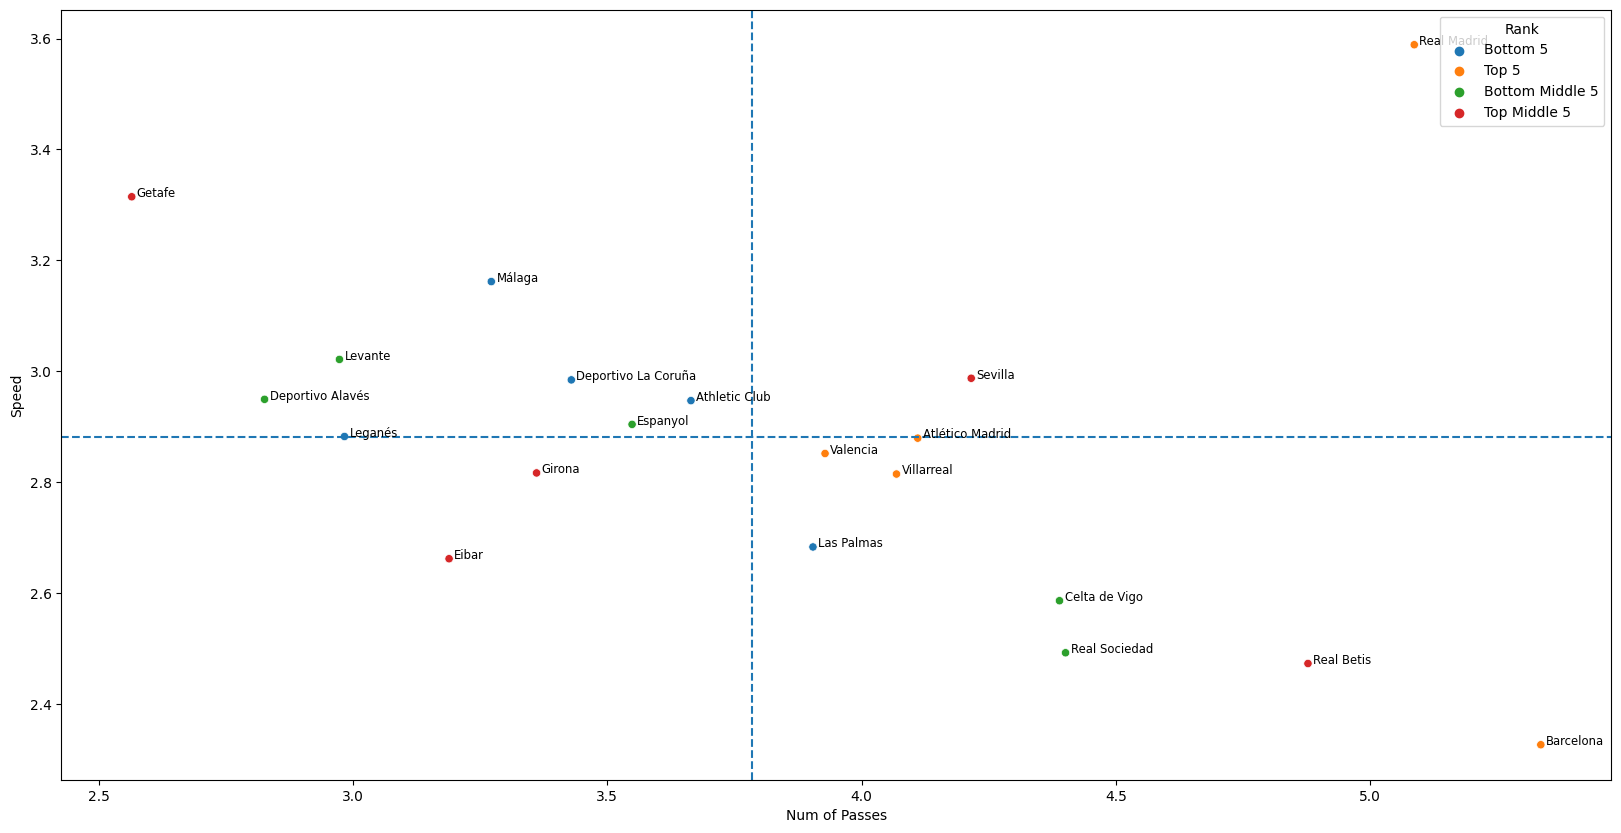

In [ ]:
# Visualizing that style
speed_med = team_style_grouped['Speed'].median()
pass_med = team_style_grouped['Num of Passes'].median()
ax = plt.figure(figsize=(20,10))
plt1 = sns.scatterplot(data = team_style_grouped, x='Num of Passes', y='Speed',hue = 'Rank')
plt1.axvline(x = pass_med, ymin = 0, ymax = 1,linestyle = "dashed")
plt1.axhline(y = speed_med, xmin = 0, xmax = 1,linestyle = "dashed")
for line in range(0,team_style_grouped.shape[0]):
     plt1.text(team_style_grouped['Num of Passes'][line]+0.01, team_style_grouped.Speed[line],
     team_style_grouped.index[line], horizontalalignment='left',
     size='small')

In [ ]:
# Encoding the Categorical columns
need_encode = ['First Event','Match Period','Side']
encoded_order = []
perform_encoded = perform.copy()
for i in need_encode:
  data = perform[i]
  le = LabelEncoder()
  le.fit(data)
  encoded_order.append(le.classes_)
  encoded_data = le.transform(data)
  perform_encoded[i] = encoded_data
perform_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)
perform_encoded.dropna(inplace=True)

In [ ]:
# Displaying the enocded order of each column
for i in encoded_order:
  print(i)

['Duel' 'Free Kick' 'Goalkeeper leaving line' 'Interruption'
 'Others on the ball' 'Pass' 'Save attempt' 'Shot']
['1H' '2H']
['away' 'home']


In [ ]:
# Dividing the data in train and test subsets
y = perform_encoded.Successful
X = perform_encoded.drop(['Successful','Sequence','Name'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Training the first model
cdt = tree.DecisionTreeClassifier()
cdt.fit(X_train, y_train)
y_pred = cdt.predict(X_test)
accuracy_score(y_test,y_pred)

0.8069959443800695

In [ ]:
# Extracting the alphas to prune the tree to reduce complexcity
alphas = cdt.cost_complexity_pruning_path(X_train, y_train)['ccp_alphas']

In [ ]:
# Getting the best alpha that prunes that tree without sacrificing the accuracy
param_grid = [{
    'ccp_alpha': alphas}]
dt = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(dt, param_grid,scoring='accuracy',cv=3)
grid_search.fit(X_train,y_train)
best_parameters = grid_search.best_params_
score = grid_search.best_score_

In [ ]:
# Displaying the best parameters with its score
print(best_parameters)
print(score)

{'ccp_alpha': 0.0001245433646272596}
0.8366829621582474


In [ ]:
# Extracting the best model and testing it with test subset
best_cdt = grid_search.best_estimator_
y_pred = best_cdt.predict(X_test)
accuracy_score(y_test,y_pred)

0.8409617612977984

In [ ]:
# Saving the Tree
features = [u'{}'.format(c) for c in X_train.columns]
classes = [u'{}'.format(c) for c in best_cdt.classes_]
dot_data = StringIO()
tree.export_graphviz(best_cdt, out_file=dot_data,
                                feature_names=features,
                                class_names=classes,
                                filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('/content/drive/MyDrive/thesis/La Liga/La_Liga_DT.png')

True

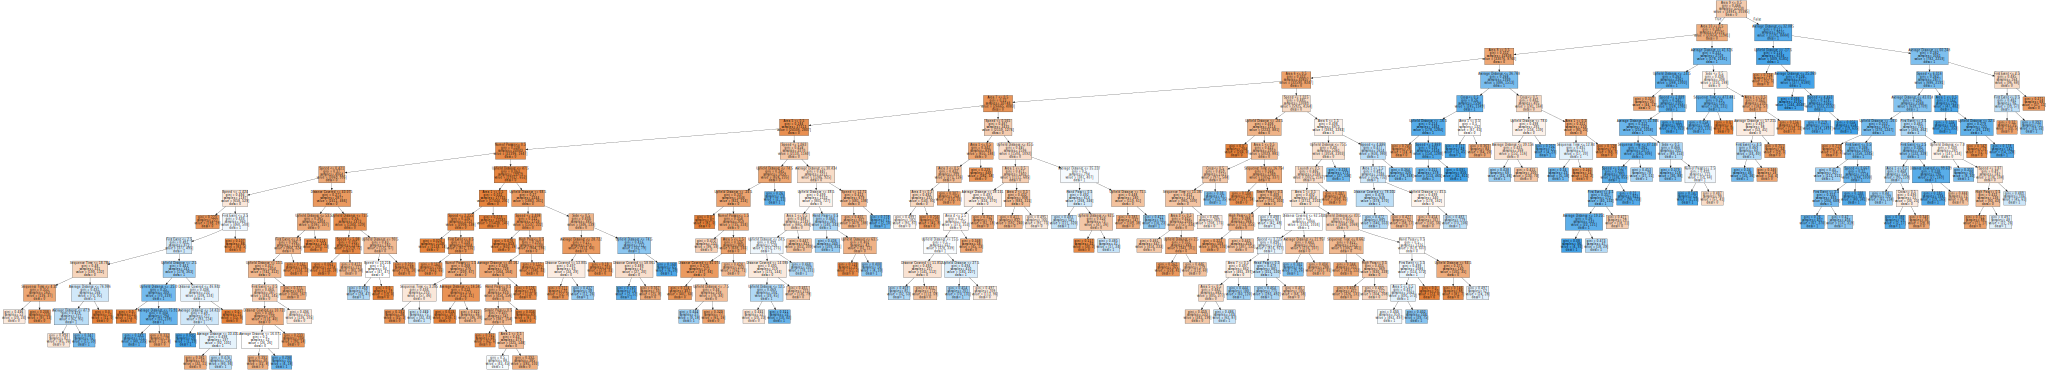

In [ ]:
# Visulaizing the Tree
features = [u'{}'.format(c) for c in X_train.columns]
classes = [u'{}'.format(c) for c in best_cdt.classes_]
dot_data = tree.export_graphviz(best_cdt, out_file=None,
                                feature_names=features,
                                class_names=classes,
                                filled=True)
graph = graphviz.Source(dot_data, format="png")
graph

# Question 2:	How can event sequence analysis identify the key players and positions that contribute most to a team's success in football, and what insights can be gained from this analysis?

In [ ]:
# Transforming the teams data to H5 format
teams.to_hdf('Liga.h5', key='teams', mode='w')

# Transforming the players data to H5 format
players.to_hdf('Liga.h5', key='players', mode='a')

# Transforming the matches data to H5 format
matches.to_hdf('Liga.h5', key='matches', mode='a')

# Transforming the event data to H5 format grouped per
events_grouped_per_match = Liga.groupby('matchId', as_index=False)
for id, events_per_match in events_grouped_per_match:
  events_per_match.to_hdf('Liga.h5', key=f'events/match_{id}', mode='a')

# Converting the above data to SPAL format
convert_to_spadl('Liga.h5', 'spadl.h5')

<ipython-input-19-37479fc0c155>:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['city', 'name', 'officialName', 'area', 'type'], dtype='object')]

  teams.to_hdf('Liga.h5', key='teams', mode='w')
<ipython-input-19-37479fc0c155>:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['passportArea', 'firstName', 'middleName', 'lastName', 'currentTeamId',
       'birthDate', 'role', 'birthArea', 'foot', 'shortName',
       'currentNationalTeamId'],
      dtype='object')]

  players.to_hdf('Liga.h5', key='players', mode='a')
<ipython-input-19-37479fc0c155>:8: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_valu

...Inserting actiontypes
...Inserting bodyparts
...Inserting results
...Converting games
...Converting players
...Converting teams
...Generating player_games


100%|██████████| 380/380 [00:41<00:00,  9.17game/s]


...Converting events to actions


100%|██████████| 380/380 [05:08<00:00,  1.23game/s]


In [ ]:
# Reading the required datasets from the SPAL format
games = pd.read_hdf('spadl.h5', key='games')
action_types = pd.read_hdf('spadl.h5', key='actiontypes')
body_parts = pd.read_hdf('spadl.h5', key='bodyparts')
results = pd.read_hdf('spadl.h5', key='results')

In [ ]:
# Grouping all the necessary feature generators
functions_features = [
    features.actiontype_onehot,
    features.bodypart_onehot,
    features.result_onehot,
    features.goalscore,
    features.startlocation,
    features.endlocation,
    features.movement,
    features.space_delta,
    features.startpolar,
    features.endpolar,
    features.team,
    features.time_delta
]

# Retrieving the column names generated by the features
columns_features = features.feature_column_names(functions_features, nb_prev_actions=3)

# Grouping the target feature generators
functions_labels = [labels.scores,labels.concedes]
target_features = ['scores','concedes']

In [ ]:
# Extracting the necessary features
for id, game in tqdm(games.iterrows(), total=len(games)):

# Extracting Events data from SPAL format
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    actions = (actions
        .merge(action_types, how='left')
        .merge(results, how='left')
        .merge(body_parts, how='left')
        .reset_index(drop=True)
    )

# Transforming the events to Game States
    gamestates = features.gamestates(actions, nb_prev_actions=3)
    gamestates = features.play_left_to_right(gamestates, game['home_team_id'])

# Extracting the features stated above and transforming it to H5 format
    features_df = pd.concat([function(gamestates) for function in functions_features], axis=1)
    features_df.to_hdf('features.h5', key=f'game_{game_id}')

  0%|          | 0/380 [00:00<?, ?it/s]

In [ ]:
# Extracting the necessary features
for id, game in tqdm(games.iterrows(), total=len(games)):

# Extracting Events data from SPAL format
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    actions = (actions
        .merge(action_types, how='left')
        .merge(results, how='left')
        .merge(body_parts, how='left')
        .reset_index(drop=True)
    )

# Extracting the labels stated above and transforming it to H5 format
    labels_df = pd.concat([function(actions) for function in functions_labels], axis=1)
    labels_df.to_hdf('labels.h5', key=f'game_{game_id}')

  0%|          | 0/380 [00:00<?, ?it/s]

In [ ]:
# Retreiving the relevant features and transforming them into a panda dataframe
features_list = []
for id, game in tqdm(games.iterrows(), total=len(games)):
    game_id = game['game_id']
    features_per_game = pd.read_hdf('features.h5', key=f'game_{game_id}')
    features_list.append(features_per_game[columns_features])
features_df = pd.concat(features_list).reset_index(drop=True)

  0%|          | 0/380 [00:00<?, ?it/s]

In [ ]:
# Visualizing the table to see how the features looks
features_df.head()

,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,type_take_on_a0,type_foul_a0,type_tackle_a0,...,end_dist_to_goal_a0,end_angle_to_goal_a0,end_dist_to_goal_a1,end_angle_to_goal_a1,end_dist_to_goal_a2,end_angle_to_goal_a2,team_1,team_2,time_delta_1,time_delta_2
0,True,False,False,False,False,False,False,False,False,False,...,68.133435,0.241882,68.133435,0.241882,68.133435,0.241882,True,True,0.000000,0.000000
1,True,False,False,False,False,False,False,False,False,False,...,41.747768,0.753381,68.133435,0.241882,68.133435,0.241882,True,True,3.146075,3.146075
2,True,False,False,False,False,False,False,False,False,False,...,39.962482,1.017502,41.747768,0.753381,68.133435,0.241882,True,True,3.238664,6.384739
3,False,False,True,False,False,False,False,False,False,False,...,80.147936,0.410167,90.620086,0.384605,79.833427,0.365852,False,False,15.901476,19.140140
4,True,False,False,False,False,False,False,False,False,False,...,78.506876,0.428778,80.147936,0.410167,90.620086,0.384605,True,False,0.962895,16.864371


In [ ]:
# Retreiving the relevant labels and transforming them into a panda dataframe
labels_list = []
for id, game in tqdm(games.iterrows(), total=len(games)):
    game_id = game['game_id']
    labels_per_game = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    labels_list.append(labels_per_game[target_features])
labels_df = pd.concat(labels_list).reset_index(drop=True)

  0%|          | 0/380 [00:00<?, ?it/s]

In [ ]:
# Visualizing the table to see how the features looks
labels_df.head()

,scores,concedes
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False


In [ ]:
print(len(labels_df))
print(len(labels_df))

474875
474875


In [ ]:
# Training a classifier model for each label
models = {}
for label in target_features:
    model = XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False
    )
    model.fit(features_df, labels_df[label])
    models[label] = model

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [ ]:
# Using the trained models to transform the labels dataframe from true/false to probability of being true
probabilities_dict = {}
for label in target_features:
    model = models[label]
    probabilities = model.predict_proba(features_df)
    predictions = probabilities[:, 1]
    probabilities_dict[label] = pd.Series(predictions)
probabilities_df = pd.concat(probabilities_dict, axis=1)

In [ ]:
# Extracting the game ids to have them with probabilties df and merging both into one
games_ids_list = []
for id, game in tqdm(games.iterrows(), total=len(games)):
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    games_ids_list.append(actions['game_id'])
game_ids_df = pd.concat(games_ids_list, axis=0).astype('int').reset_index(drop=True)
probabilities_df = pd.concat([probabilities_df, game_ids_df], axis=1)

  0%|          | 0/380 [00:00<?, ?it/s]

In [ ]:
# Visualizing the table to see how the probabilities looks
probabilities_df.head()

,scores,concedes,game_id
0,0.003779,0.001409,2565922
1,0.004061,0.000298,2565922
2,0.004209,0.000630,2565922
3,0.002292,0.000844,2565922
4,0.003531,0.005266,2565922


In [ ]:
# Grouping the probabilities by match
probabilities_per_game = probabilities_df.groupby('game_id')

# Saving them in H5 format
for game_id, probabilities in tqdm(probabilities_per_game):
    probabilities = probabilities.reset_index(drop=True)
    probabilities[target_features].to_hdf('probabilities.h5', key=f'game_{game_id}')

  0%|          | 0/380 [00:00<?, ?it/s]

In [ ]:
# VAEP Calculations
players = pd.read_hdf('spadl.h5', key='players')
teams = pd.read_hdf('spadl.h5', key='teams')
all_per_game = []

for id, game in tqdm(games.iterrows(), total=len(games)):

# Extracting all required data to calculate VAEP
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    actions = (actions
        .merge(action_types, how='left')
        .merge(results, how='left')
        .merge(body_parts, how='left')
        .merge(players, how='left')
        .merge(teams, how='left')
        .reset_index(drop=True)
    )
    probabilities_df = pd.read_hdf('probabilities.h5', key=f'game_{game_id}')
# Calculating VAEP
    values = value(actions, probabilities_df['scores'], probabilities_df['concedes'])

# Saving all to list
    all_df = pd.concat([actions, probabilities_df, values], axis=1)
    all_per_game.append(all_df)

# transforming all to pandas dataframe
vaep_rating = pd.concat(all_per_game)

  0%|          | 0/380 [00:00<?, ?it/s]

In [ ]:
# Extracting minutes played by player
player_games = pd.read_hdf('spadl.h5', 'player_games')
player_games = player_games[player_games['game_id'].isin(games['game_id'])]
minutes_played = (player_games[['player_id', 'minutes_played']]
    .groupby('player_id')
    .sum()
    .reset_index()
)

In [ ]:
# Aggregating the results and grouping them by player
players_ratings = (vaep_rating[['player_id', 'team_name', 'short_name', 'vaep_value']]
    .groupby(['player_id', 'team_name', 'short_name'])
    .agg(vaep_count=('vaep_value', 'count'), vaep_sum=('vaep_value', 'sum'), vaep_mean=('vaep_value', 'mean'),)
    .sort_values('vaep_sum', ascending=False)
    .reset_index()
)

# Adding column minutes played total per player
players_ratings = players_ratings.merge(minutes_played)

# Removing any player plaing less than 450 minutes (5 matches all league)
players_ratings = players_ratings[players_ratings['minutes_played'] > 450]

# Transforming VAEP to show players rating per match
players_ratings['vaep_per_match'] = players_ratings['vaep_sum'] * 90 / players_ratings['minutes_played']

# Average actions per plaer per match
players_ratings['actions_per_match'] = players_ratings['vaep_count'] * 90 / players_ratings['minutes_played']

# Sorting value by VAEP per match
players_ratings = players_ratings.sort_values('vaep_per_match', ascending=False)

In [ ]:
# Adding two more columns that describes VAEP rating into success and fail actions
risk = pd.pivot_table(vaep_rating, values='vaep_value', index=['player_id', 'short_name', 'team_name'],
                                              columns=['result_name'], aggfunc=np.sum,
                                              fill_value=0)[['success', 'fail']]
risk = risk.reset_index()
risk = risk[0:-1]
risk = risk[['player_id','success','fail']]

# Merging these two columns with the players ratings
players_ratings = pd.merge(players_ratings, risk, on=['player_id'])

# Normalizing them to 90 minutes
players_ratings['success'] = players_ratings['success'] / players_ratings['minutes_played'] * 90
players_ratings['fail'] = players_ratings['fail'] / players_ratings['minutes_played'] * 90

In [ ]:
# Visualizing the players ratings
players_ratings.head()

,player_id,team_name,short_name,vaep_count,vaep_sum,vaep_mean,minutes_played,vaep_per_match,actions_per_match,success,fail
0,3359.0,FC Barcelona,L. Messi,2753,38.016789,0.013809,3107.979597,1.100879,79.720601,1.546329,-0.421932
1,3682.0,Club Atlético de Madrid,A. Griezmann,1394,16.577530,0.011892,2620.010232,0.569455,47.885309,0.755899,-0.179501
2,8278.0,Real Madrid Club de Fútbol,G. Bale,1104,11.502384,0.010419,1852.140087,0.558929,53.646050,0.833687,-0.265363
3,3802.0,FC Barcelona,Philippe Coutinho,1155,8.243649,0.007137,1329.240751,0.558160,78.202538,0.858447,-0.295461
4,225946.0,Real Betis Balompié,A. Sanabria,239,5.354232,0.022403,901.735926,0.534392,23.853990,0.708078,-0.172252


In [ ]:
# Getting the top 4 leagues positions data
api=StatsBombLoader(getter="remote",creds=None)
spain = api.games(competition_id=11,season_id=1)

/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [ ]:
list_of_players = []
# Extracting the position of players in La Liga
unique_games = spain['game_id'].unique()
for game in unique_games:
  plrs = api.players(game_id=	game)
  tms = api.teams(game_id=game)
  plrs_merged = pd.merge(plrs,tms, on=["team_id"])
  extracted = plrs_merged[['player_id','player_name','starting_position_name','team_name']]
  list_of_players.append(extracted)

/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: 

In [ ]:
# Putting all together
players_position = pd.concat(list_of_players)
players_position.head()

,player_id,player_name,starting_position_name,team_name
0,3501,Philippe Coutinho Correia,Right Midfield,Barcelona
1,5203,Sergio Busquets i Burgos,Right Defensive Midfield,Barcelona
2,5211,Jordi Alba Ramos,Left Back,Barcelona
3,5213,Gerard Piqué Bernabéu,Right Center Back,Barcelona
4,5216,Andrés Iniesta Luján,Left Midfield,Barcelona


In [ ]:
# Determining the position the most played by each player
names = []
position = []
for name in players_position.player_name.unique():
  position_per_player = players_position[players_position['player_name']==name]
  names.append(name)
  if position_per_player.starting_position_name.value_counts().index[0] == 'Substitute':
    try:
      position.append(position_per_player.starting_position_name.value_counts().index.tolist()[1])
    except:
      position.append(position_per_player.starting_position_name.value_counts().index.tolist()[0])
  else:
    position.append(position_per_player.starting_position_name.value_counts().index.tolist()[0])
players_position = pd.DataFrame(list(zip(names, position)),columns =['player_name', 'position'])

In [ ]:
# Function that matches names from 2 Dataframes
def fuzzy_merge(df_1, df_2, key1, key2, threshold=0, limit=1):
    s = df_2[key2].tolist()
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit,scorer=fuzz.token_set_ratio ))
    df_1['matches'] = m
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    return df_1

In [ ]:
# Applying the function
players_ratings = fuzzy_merge(players_ratings, players_position, 'short_name', 'player_name')

In [ ]:
# Creating a new column for each player and his position
positions = []
for id,row in players_ratings.iterrows():
  player = row['matches']
  info = players_position[players_position['player_name']==player]
  position = info['position'].iloc[0]
  positions.append(position)
players_ratings['position'] = positions

In [ ]:
# Understanding the number of players in each position
players_ratings.groupby(['position'])['position'].count()


position
Center Attacking Midfield     8
Center Back                   1
Center Defensive Midfield    17
Center Forward               17
Center Midfield               3
Goalkeeper                   39
Left Back                    32
Left Center Back             31
Left Center Forward          10
Left Center Midfield         14
Left Defensive Midfield      22
Left Midfield                24
Left Wing                    16
Left Wing Back                1
Right Back                   34
Right Center Back            34
Right Center Forward         22
Right Center Midfield         8
Right Defensive Midfield     22
Right Midfield               23
Right Wing                   14
Substitute                   80
Name: position, dtype: int64

In [ ]:
# Putting all CBs, RCBs and LCBs as CBs
players_ratings.replace('Left Center Back','Center Back', inplace = True)
players_ratings.replace('Right Center Back','Center Back', inplace = True)

# Putting all CFs, RCFs and LCFs as CFs
players_ratings.replace('Left Center Forward','Center Forward', inplace = True)
players_ratings.replace('Right Center Forward','Center Forward', inplace = True)

# Putting all CFs, RCFs and LCFs as CFs
players_ratings.replace('Left Defensive Midfield','Center Defensive Midfield', inplace = True)
players_ratings.replace('Right Defensive Midfield','Center Defensive Midfield', inplace = True)

# Putting all RWBs to RBs and LWBs to LBs
players_ratings.replace('Left Wing Back','Left Back', inplace = True)
players_ratings.replace('Right Wing Back','Right Back', inplace = True)
players_ratings.replace('Center Midfield','Right Center Midfield', inplace = True)

In [ ]:
# Abbreviating all positions
players_ratings.replace('Left Center Midfield','LCM', inplace = True)
players_ratings.replace('Center Attacking Midfield','CAM', inplace = True)
players_ratings.replace('Left Wing','LW', inplace = True)
players_ratings.replace('Right Midfield','RM', inplace = True)
players_ratings.replace('Right Wing','RW', inplace = True)
players_ratings.replace('Right Center Midfield','RCM', inplace = True)
players_ratings.replace('Substitute','Sub', inplace = True)
players_ratings.replace('Left Back','LB', inplace = True)
players_ratings.replace('Center Defensive Midfield','CDM', inplace = True)
players_ratings.replace('Left Midfield','LM', inplace = True)
players_ratings.replace('Center Forward','CF', inplace = True)
players_ratings.replace('Right Back','RB', inplace = True)
players_ratings.replace('Center Back','CB', inplace = True)
players_ratings.replace('Goalkeeper','GK', inplace = True)

In [ ]:
# Aggregating and grouping by player position
positions_ranks = players_ratings.groupby(['position']).mean()

<ipython-input-49-ea2832b3073a>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  positions_ranks = players_ratings.groupby(['position']).mean()


In [ ]:
# Seeing the table
positions_ranks

,player_id,vaep_count,vaep_sum,vaep_mean,minutes_played,vaep_per_match,actions_per_match,success,fail
position,,,,,,,,,
CAM,98707.125000,959.250000,2.343645,0.001713,1486.247001,0.109093,57.913570,0.251332,-0.139720
CB,64454.636364,1284.878788,3.530776,0.002786,2090.133389,0.151615,55.365858,0.199626,-0.047492
CDM,108853.000000,989.918033,2.600156,0.002086,1634.107269,0.112314,48.985780,0.194446,-0.080413
CF,58441.857143,853.306122,4.401061,0.003982,1793.124995,0.181566,40.482662,0.349264,-0.164933
GK,43284.358974,804.564103,2.179626,0.002507,1967.314410,0.097795,38.429683,0.145157,-0.045321
LB,96350.121212,1170.818182,3.159480,0.003418,1838.408886,0.151483,54.542697,0.246819,-0.093158
LCM,68073.214286,1065.142857,3.006988,0.002481,1840.410712,0.132464,49.862620,0.202408,-0.068456
LM,102761.583333,1102.791667,3.768957,0.003402,1958.356741,0.179590,51.778053,0.291297,-0.108553
LW,70265.812500,998.750000,3.264860,0.002428,1656.977245,0.145909,54.579370,0.311031,-0.160478


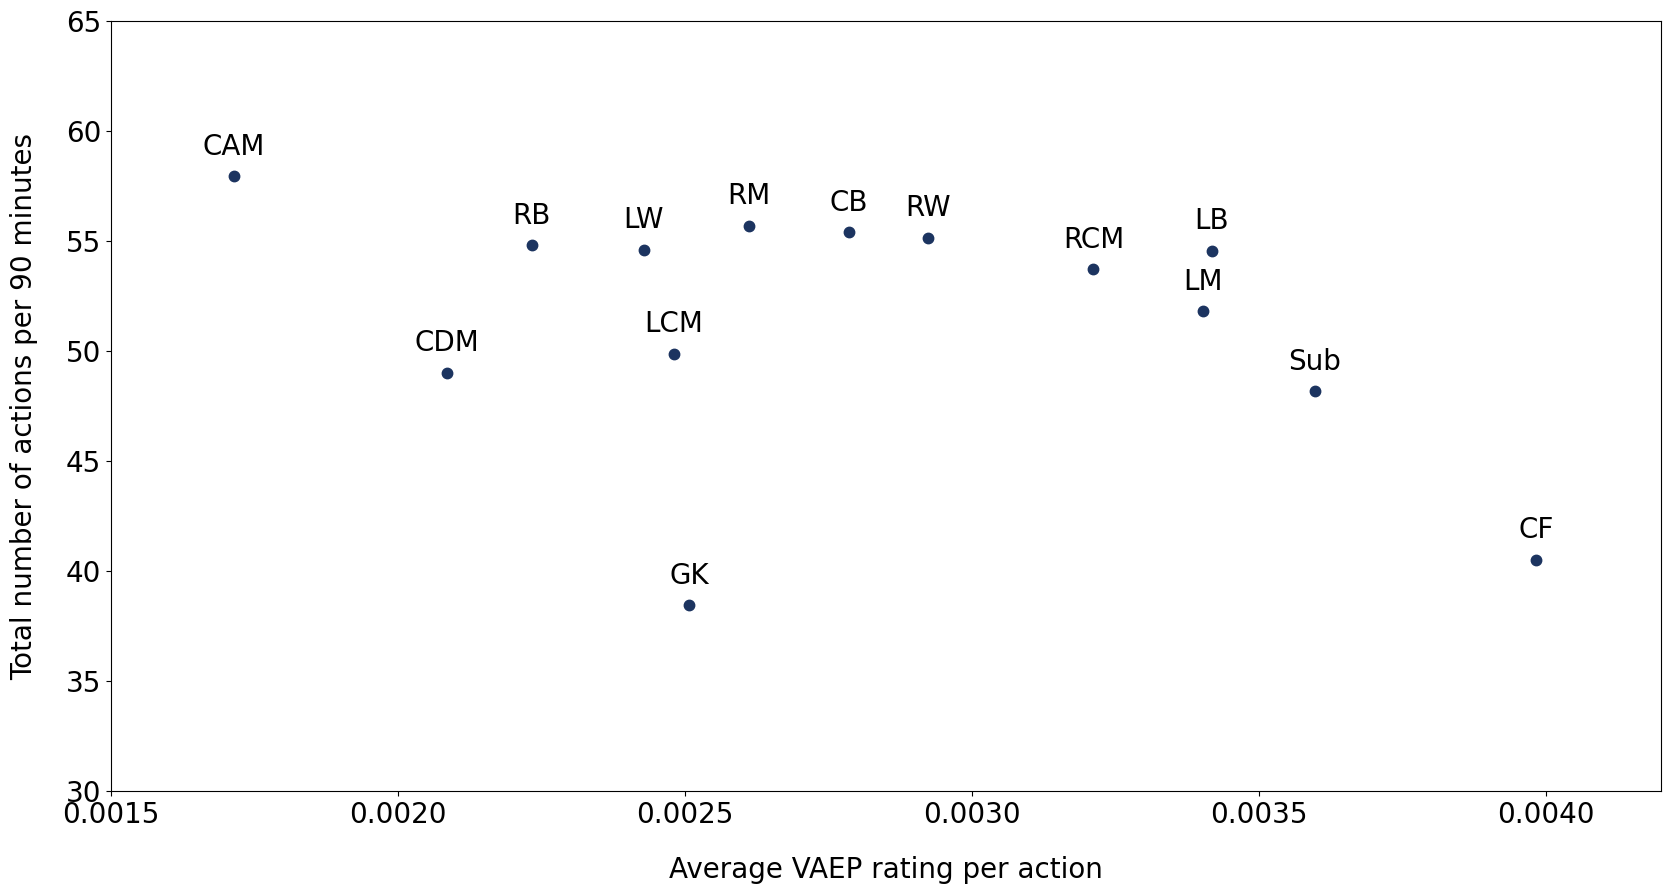

In [ ]:
# Analyzing Quantity vs Quality
positions_ranks = positions_ranks.sort_values('vaep_per_match', ascending=False)
plt.figure(figsize=(20, 10))
x = list(positions_ranks['vaep_mean'])
y = list(positions_ranks['actions_per_match'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

names = positions_ranks.index.values.tolist()
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 1), fontsize=20, horizontalalignment='center')


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0.0015, 0.0042)
plt.ylim(30, 65)
plt.xlabel('Average VAEP rating per action', labelpad=20, fontsize=20)
plt.ylabel('Total number of actions per 90 minutes', labelpad=20, fontsize=20)
plt.show()

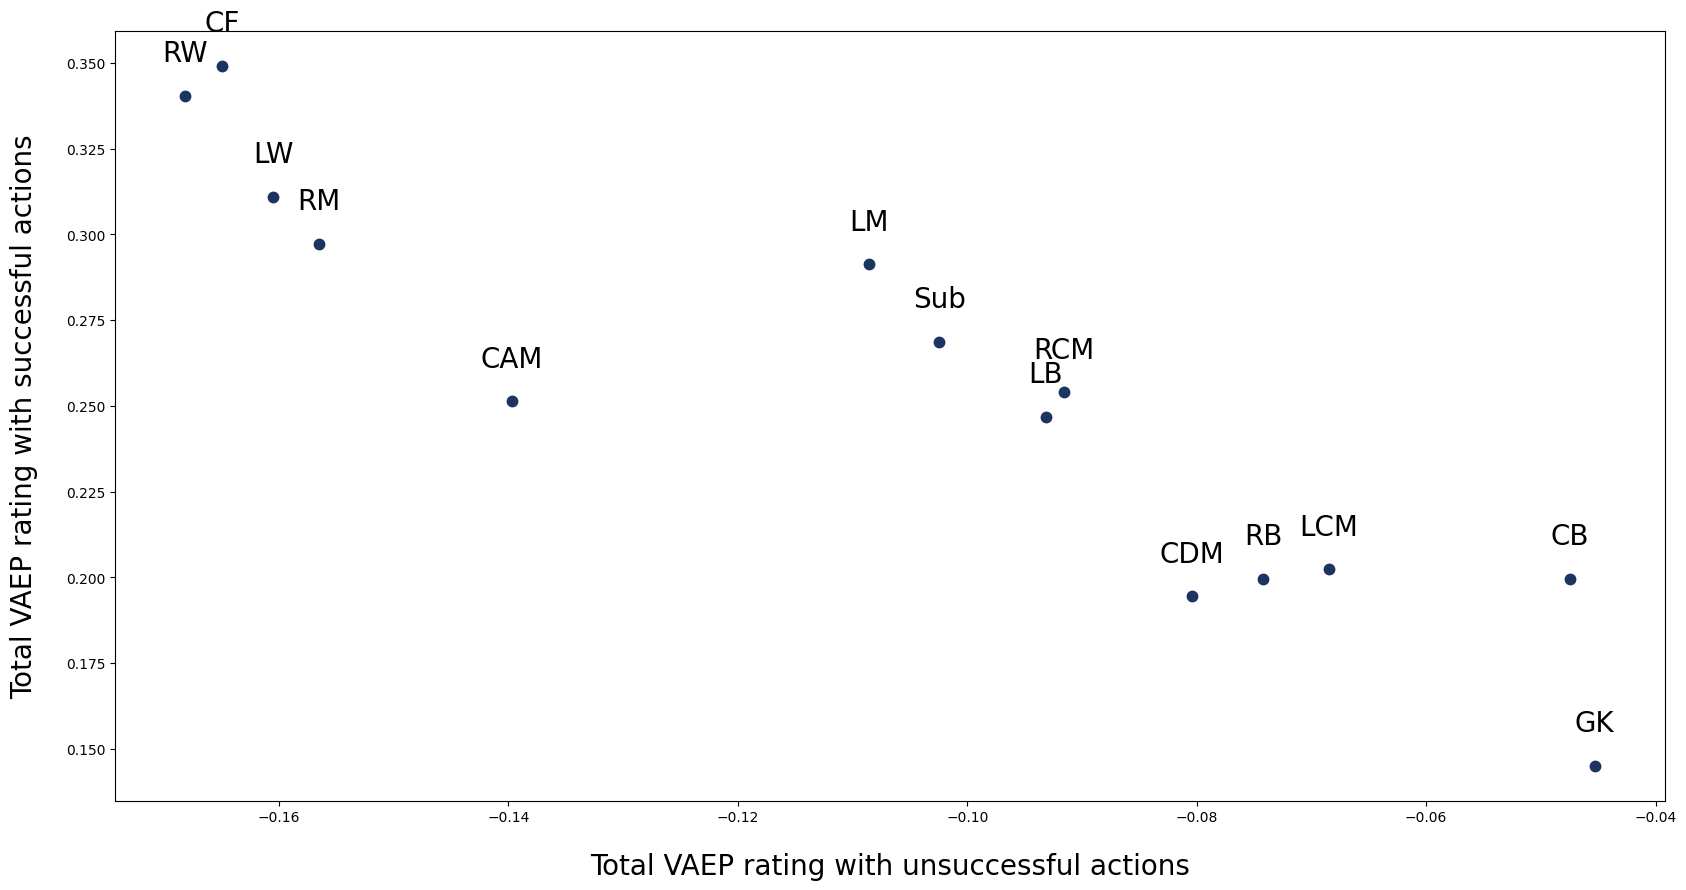

In [ ]:
# Analyzing Risk taken by position
positions_ranks = positions_ranks.sort_values('vaep_per_match', ascending=False)
plt.figure(figsize=(20, 10))
x = list(positions_ranks['fail'])
y = list(positions_ranks['success'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

names = positions_ranks.index.values.tolist()
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i]+ 0.01), fontsize=20, horizontalalignment='center')

plt.xlabel('Total VAEP rating with unsuccessful actions', labelpad=20, fontsize=20)
plt.ylabel('Total VAEP rating with successful actions', labelpad=20, fontsize=20)
plt.show()

In [ ]:
# Getting Best 3 position by Club
positions_ranks_by_club = players_ratings.groupby(['team_name','position']).mean().sort_values(['team_name', 'vaep_per_match'], ascending=[True, False])
positions_ranks_by_club.groupby(level=0).head(3)

<ipython-input-53-290b12a981b2>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  positions_ranks_by_club = players_ratings.groupby(['team_name','position']).mean().sort_values(['team_name', 'vaep_per_match'], ascending=[True, False])


player_id   vaep_count  \
team_name                        position                               
Athletic Club Bilbao             GK          3411.000000   867.500000   
                                 Sub       286963.000000   505.000000   
                                 CB        239285.000000  1557.500000   
CD Leganés                       RW          3934.000000   989.000000   
                                 LB        169002.000000  1718.000000   
                                 CF         14602.333333   709.333333   
Club Atlético de Madrid          RCM         3443.000000  2510.000000   
                                 CF          3820.333333  1312.666667   
                                 LM        134769.000000   516.000000   
Deportivo Alavés                 LM          3423.000000  1291.000000   
                                 Sub       278278.000000  1033.000000   
                                 LB        292434.500000  1281.500000   
FC Barcelona                     CF          5665.500000  2151.000000   
                                 LM          5838.000000  1192.000000   
                                 CDM         3411.000000  2698.000000   
Getafe Club de Fútbol            RB          3468.000000   861.000000   
                                 LB         37071.250000   722.750000   
                                 RM          3572.000000  1326.000000   
Girona FC                        Sub        25459.750000  1056.000000   
                                 CDM       238583.500000  1987.500000   
                                 LW          4278.000000  1840.000000   
Levante UD                       LB        169645.333333  1273.000000   
                                 CDM       245729.000000   764.500000   
                                 LCM        26032.000000   444.000000   
Málaga Club de Fútbol            RB          3958.250000  1227.500000   
                                 CB         12531.666667   972.333333   
                                 LM        191811.500000   500.500000   
Real Betis Balompié              Sub       245269.250000   630.750000   
                                 CB         11223.000000  1781.000000   
                                 RW        346195.000000  2539.000000   
Real Club Celta de Vigo          LM        241945.000000  1578.000000   
                                 CB         30952.666667  1355.666667   
                                 RB         15284.000000  1767.000000   
Real Club Deportivo de La Coruña RW          4879.000000   311.000000   
                                 LCM        51004.000000  1455.000000   
                                 LW          3451.000000  1266.000000   
Real Madrid Club de Fútbol       RW          8278.000000  1104.000000   
                                 LCM        14723.000000  2496.000000   
                                 LW          3322.000000  1182.000000   
Real Sociedad de Fútbol          RCM         3576.000000   560.000000   
                                 CDM         3678.000000  2316.500000   
                                 RM        132204.500000  1358.500000   
Reial Club Deportiu Espanyol     LM          3560.000000  1425.000000   
                                 CB         72864.500000  1263.250000   
                                 CF          5025.250000   770.000000   
SD Eibar                         LB         12608.000000  1395.000000   
                                 Sub       194726.500000   569.000000   
                                 RW          3968.500000  1338.000000   
Sevilla FC                       Sub        44492.571429   713.857143   
                                 RCM        56025.000000   455.000000   
                                 LCM         8200.000000  2055.000000   
UD Las Palmas                    CAM         4379.000000  1897.000000   
                                 Sub       134390.666667   505.666667   
                                

# Question 3

## Process Mining preparation

In [ ]:
# Getting list of matches ID for Barcelona and Real Madrid
all_bar_real_matches = list(matches[(matches['label'].str.contains('Barcelona')) | (matches['label'].str.contains('Real Madrid'))]['wyId'])

# FIltering out non Barcelona and Real Madrid events
Liga = Liga[Liga['matchId'].isin(all_bar_real_matches)]

In [ ]:
# Adding a row that will help in determining the end of a sequence
Liga['sequence_analysis'] = Liga['teamId'].shift(1)
print(Liga[Liga.eventName=='Foul'].subEventName.unique())
# Dropping any event that saved as Foul as this is irrelevant to the data as it just describes the type of foul given to the event before it
Liga = Liga.drop(Liga[Liga.eventName=='Foul'].index)

['Foul' 'Protest' 'Hand foul' 'Violent Foul' 'Out of game foul'
 'Late card foul' 'Simulation' 'Time lost foul']


In [ ]:
seq = 0
top_5 = ['Villarreal','Real Madrid', 'Barcelona', 'Atlético Madrid','Valencia']
top_middle = ['Sevilla', 'Real Betis','Getafe','Eibar','Girona']
bottom_middle = ['Real Sociedad','Celta de Vigo','Espanyol','Levante','Deportivo Alavés']
# Creating a Column stating whether the team is playing home or away
def team_side(row):
  teams_data = matches[matches['wyId']==row.matchId].iloc[0]['teamsData']
  side = teams_data[str(row.teamId)]['side']
  return side

# Creating a Column Stating the team's Name
def team_name(row):
    name = teams[teams['wyId']==row.teamId].iloc[0]['name'].encode().decode('unicode-escape')
    return name

# Creating a column stating y position
def start_y(row):
  position = row.positions[0]['y']
  return position

# Creating a column ending y position
def end_y(row):
  position = row.positions[1]['y']
  return position

# Creating a column stating x position
def start_x(row):
  position = row.positions[0]['x']
  return position

# Creating a column ending x position
def end_x(row):
  position = row.positions[1]['x']
  return position

# Creating a timestamp column
def timestamp(row):
    time = matches[matches['wyId']==row.matchId].iloc[0]['dateutc'].split()
    start_time = datetime.strptime(time[1],'%H:%M:%S')
    start_time_sec = start_time.second + start_time.minute*60 + start_time.hour*3600
    if row.matchPeriod=='2H':
      time_stamp = time[0] + 'T' + str(timedelta(seconds=row.eventSec + 3600 + start_time_sec))
    else:
      time_stamp = time[0] + 'T' + str(timedelta(seconds=row.eventSec + start_time_sec))
    return time_stamp

# Grouping events into sequence
def sequence_groups(row):
  global seq
  if row.sequence_analysis==row.teamId:
    sequence = seq
  else:
    seq+=1
    sequence = seq
  return sequence

# Creating a Column of Match Rank
def type_of_match(row):
  teams_data = matches[matches['wyId']==row.matchId].iloc[0]['teamsData']
  teams_in_match = list(teams_data.keys())
  teams_in_match.remove(str(row.teamId))
  against = int(teams_in_match[0])
  teams_in_play = [row.teamId, against]
  team_rank = []
  for i in teams_in_play:
    name = teams[teams['wyId']==i].iloc[0]['name']
    if name in top_5:
      team_rank.append('Top 5')
    elif name in top_middle:
      team_rank.append('Top Middle 5')
    elif name in bottom_middle:
      team_rank.append('Bottom Middle 5')
    else:
      team_rank.append('Bottom 5')

  match_rank = ' vs '.join(team_rank)
  return match_rank

# Adding a Column outcome of the match
def status(row):
  label = matches[matches['wyId']==row.matchId].iloc[0]['label']
  winner = matches[matches['wyId']==row.matchId].iloc[0]['winner']
  if 'Barcelona' in label and winner==676:
    return 'Win'
  elif 'Real Madrid' in label and winner==675:
    return 'Win'
  elif winner==0:
    return 'Draw'
  else:
    return 'Lose'

# Calculating the Columns
Liga['Side'] = Liga.apply(team_side,axis=1)
Liga['Name'] = Liga.apply(team_name,axis=1)
Liga['start_y'] = Liga.apply(start_y,axis=1)
Liga['end_y'] = Liga.apply(end_y,axis=1)
Liga['start_x'] = Liga.apply(start_x,axis=1)
Liga['end_x'] = Liga.apply(end_x,axis=1)
Liga['Timestamp'] = Liga.apply(timestamp,axis=1)
Liga['Sequence'] = Liga.apply(sequence_groups,axis=1)
Liga['Match Rank'] = Liga.apply(type_of_match,axis=1)
Liga['Outcome'] = Liga.apply(status,axis=1)
Liga['total_distance'] = Liga['end_x'] - Liga['start_x']

In [ ]:
# Removing all Sequences that are shorter than 3 Events
Liga = Liga[Liga.groupby('Sequence').Sequence.transform('count') > 2]

# Selecting last event in each sequece to analyze whether it was a sucessful sequence or not
end_event = Liga.groupby('Sequence').last()

# Understanding how can a sequence end by displaying all possible end
for i in end_event.eventName.unique():
  print(i)
  df = end_event[(end_event['eventName']==i)]
  print(df.subEventName.unique())

Duel
['Ground attacking duel' 'Ground defending duel' 'Ground loose ball duel'
 'Air duel']
Pass
['Simple pass' 'Smart pass' 'High pass' 'Cross' 'Launch' 'Head pass'
 'Hand pass']
Interruption
['Ball out of the field' 'Whistle']
Others on the ball
['Touch' 'Acceleration' 'Clearance']
Offside
['']
Shot
['Shot']
Free Kick
['Throw in' 'Goal kick' 'Corner']


In [ ]:
# Dividing sequences number into sucessful or not
successful_seq = []
un_seq = []
count = 0
for index , row in end_event.iterrows():
  count+=1
  if row.eventName == 'Shot' or row.eventName == 'Goalkeeper leaving line':
    successful_seq.append(index)
  elif (row.eventName == 'Pass' or row.eventName == 'Duel' or row.eventName == 'Others on the ball') and row.end_x>75:
    successful_seq.append(index)
  elif (row.subEventName == 'Corner' or row.subEventName == 'Free Kick'):
    successful_seq.append(index)
  else:
    un_seq.append(index)

In [ ]:
# Setting all events in a sequence to 1 if found successful in the above analysis and 0 if unsuccessful
def sucessful_seq(row):
  if row.Sequence in successful_seq:
    return 1
  elif row.Sequence in un_seq:
    return 0
Liga['Successful'] = Liga.apply(sucessful_seq,axis=1)

In [ ]:
# Adding more details for Passes
def more_pass_det(row):
  event = row.eventName
  distance = row.total_distance
  if event =='Pass':
    if abs(distance)<10:
      type_of_pass = 'S'
    elif abs(distance)<=30:
      type_of_pass = 'M'
    else:
      type_of_pass = 'L'
    if distance<0:
      type_of_pass += 'BP'
    else:
      type_of_pass += 'FP'
  else:
    type_of_pass = event
  return type_of_pass
Liga['eventName'] = Liga.apply(more_pass_det,axis=1)

In [ ]:
# Selecting the relevant rows for analysis
Liga_analyis = Liga[['Sequence', 'eventName','subEventName','playerId','matchId','Timestamp','matchPeriod','start_y','end_y','start_x','end_x','Name','Side','Match Rank','Successful','Outcome']]

In [ ]:
# For process mining it is required that all sequences begin with the same thing so adding In at the beginning
def add_row_at_beginning(x):
  data = []
  first_row = x.iloc[0]
  first_row['eventName'] = 'In'
  first_rows = dict(first_row)
  data.insert(0,first_rows)
  return pd.concat([pd.DataFrame(data), x], ignore_index=True)
Liga_analyis = Liga_analyis.groupby('Sequence').apply(add_row_at_beginning).reset_index(drop=True)

# For process mining it is required that all sequences end with the same thing so adding Out at the end
def add_row_at_end(x):
  last_row = x.iloc[-1]
  last_row['eventName'] = 'Out'
  return x.append(last_row)
Liga_analyis = Liga_analyis.groupby('Sequence').apply(add_row_at_end).reset_index(drop=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-26-f72e8f004a8d>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-26-f72e8f004a8d>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-26-f72e8f004a8d>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-26-f72e8f004a8d>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-26-f72e8f004a8d>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

In [ ]:
# Displaying the final table
Liga_analyis.head(20)

,Sequence,eventName,subEventName,playerId,matchId,Timestamp,matchPeriod,start_y,end_y,start_x,end_x,Name,Side,Match Rank,Successful,Outcome
0,1,In,Simple pass,3359,2565554,2017-08-20T18:15:01.012047,1H,50,50,50,40,Barcelona,home,Top 5 vs Top Middle 5,0,Win
1,1,MBP,Simple pass,3359,2565554,2017-08-20T18:15:01.012047,1H,50,50,50,40,Barcelona,home,Top 5 vs Top Middle 5,0,Win
2,1,SFP,Simple pass,3346,2565554,2017-08-20T18:15:03.528288,1H,50,69,40,43,Barcelona,home,Top 5 vs Top Middle 5,0,Win
3,1,SFP,Simple pass,3476,2565554,2017-08-20T18:15:06.260533,1H,69,96,43,44,Barcelona,home,Top 5 vs Top Middle 5,0,Win
4,1,MBP,Simple pass,222770,2565554,2017-08-20T18:15:08.796845,1H,96,76,44,29,Barcelona,home,Top 5 vs Top Middle 5,0,Win
5,1,SFP,Simple pass,3355,2565554,2017-08-20T18:15:11.405818,1H,76,21,29,33,Barcelona,home,Top 5 vs Top Middle 5,0,Win
6,1,SFP,Simple pass,25397,2565554,2017-08-20T18:15:15.562406,1H,21,4,33,40,Barcelona,home,Top 5 vs Top Middle 5,0,Win
7,1,SBP,Simple pass,3269,2565554,2017-08-20T18:15:17.129899,1H,4,25,40,33,Barcelona,home,Top 5 vs Top Middle 5,0,Win
8,1,SFP,Simple pass,25397,2565554,2017-08-20T18:15:22.427357,1H,25,5,33,41,Barcelona,home,Top 5 vs Top Middle 5,0,Win
9,1,MFP,Simple pass,3269,2565554,2017-08-20T18:15:25.459950,1H,5,6,41,57,Barcelona,home,Top 5 vs Top Middle 5,0,Win


In [ ]:
# Getting event data for classico match
classico_d = Liga_analyis[Liga_analyis['matchId']==2565907]

In [ ]:
# Saving the events as csv for each team for process mining
teams = classico_d.Name.unique()
success = classico_d.Successful.unique()
for team in teams:
  path  = '/content/drive/MyDrive/thesis/La Liga/classico draw '+ team
  team_events = classico_d[classico_d['Name']== team]
  for num in success:
    sub_df = team_events[team_events['Successful']==num]
    if num==1:
      final_path = path +' Success.csv'
    else:
      final_path = path +' Unsuccess.csv'
    sub_df.to_csv(final_path,index=False)

In [ ]:
# Getting event data for other classico match
classico_w = Liga_analyis[Liga_analyis['matchId']==2565711]

In [ ]:
# Saving the events as csv for each team for process mining
teams = classico_w.Name.unique()
success = classico_w.Successful.unique()
for team in teams:
  path  = '/content/drive/MyDrive/thesis/La Liga/classico win '+ team
  team_events = classico_w[classico_w['Name']== team]
  for num in success:
    sub_df = team_events[team_events['Successful']==num]
    if num==1:
      final_path = path +' Success.csv'
    else:
      final_path = path +' Unsuccess.csv'
    sub_df.to_csv(final_path,index=False)

## Prep for Decision Tree

In [ ]:
# Function to count number of passes
def number_of_passes(x):
  passes = x[x['eventName'].str.contains('Pass')]
  return len(passes)

# function to calculate total time of a sequence
def deta_time(x):
  try:
    first_event_time = x.iloc[0].split('T')[1]
    first_event_time = datetime.strptime(first_event_time, "%H:%M:%S.%f")
  except:
    first_event_time = x.iloc[0].split('T')[1]
    first_event_time = datetime.strptime(first_event_time, "%H:%M:%S")
  try:
    last_event_time = x.iloc[-1].split('T')[1]
    last_event_time = datetime.strptime(last_event_time, "%H:%M:%S.%f")
  except:
    last_event_time = x.iloc[-1].split('T')[1]
    last_event_time = datetime.strptime(last_event_time, "%H:%M:%S")
  return (last_event_time-first_event_time).total_seconds()

# Calculating the total distance covered from start point till end point
def total_distance_covered(x):
  start_x = x['start_x'].iloc[0]
  end_x = x['end_x'].iloc[-2]
  start_y = x['start_y'].iloc[0]
  end_y = x['end_y'].iloc[-2]
  total_distance = math.sqrt(((start_x-end_x)**2)+((start_y-end_y)**2))
  return total_distance

# Total upfield distance
def upfield_distance_covered(x):
  start = x['start_x'].iloc[0]
  end_x = x['end_x'].iloc[-1]
  if end_x ==0:
    if x['eventName'].iloc[-1]=='Shot':
      end = 100
    else:
      end = x['start_x'].iloc[-1]
  else:
    end = end_x
  return end-start

# Average event distance per sequence
def average_distance(x):
  sequence_distance = 0
  for i in range(len(x)):
    start_x =  x['start_x'].iloc[i]
    end_x = x['end_x'].iloc[i]
    start_y =  x['start_y'].iloc[i]
    end_y = x['end_y'].iloc[i]
    event_distance = math.sqrt(((start_x-end_x)**2)+((start_y-end_y)**2))
    sequence_distance += event_distance
  return sequence_distance/len(x)

# Number of each type of pass per Sequence
def type_pass(x):
  different_passes = dict(x.subEventName.value_counts())
# Count Simple Pass
  try:
    simple = different_passes['Simple pass']
  except:
    simple = 0
# Count High Pass
  try:
    high = different_passes['High pass']
  except:
    high = 0
# Count Head Pass
  try:
    head = different_passes['Head pass']
  except:
    head = 0
# Count Crosses
  try:
    cross = different_passes['Cross']
  except:
    cross = 0
# Count Hand Pass
  try:
    hand = different_passes['Hand pass']
  except:
    hand = 0
# Count Smart Pass
  try:
    smart = different_passes['Smart pass']
  except:
    smart = 0
# Count Launches
  try:
    launch = different_passes['Launch']
  except:
    launch = 0
  passes_list = []
  passes_list.append(simple)
  passes_list.append(high)
  passes_list.append(head)
  passes_list.append(cross)
  passes_list.append(hand)
  passes_list.append(smart)
  passes_list.append(launch)
  return passes_list

#Function to count Number of passes mae to different areas of the field
def passes_in_different_areas(x):
  passes = x[x['eventName'].str.contains('Pass')]
  area_1 = 0
  area_2 = 0
  area_3 = 0
  area_4 = 0
  area_5 = 0
  area_6 = 0
  area_7 = 0
  area_8 = 0
  area_9 = 0
  area_10 = 0
  for i in range(len(passes)):
    if passes['end_x'].iloc[i]<=50:
      area_1 += 1
    elif passes['end_x'].iloc[i]<=67:
      if passes['end_y'].iloc[i]<=19:
        area_2 += 1
      elif passes['end_y'].iloc[i]<=81:
        area_3 += 1
      else:
        area_4 += 1
    elif passes['end_x'].iloc[i]<=84:
      if passes['end_y'].iloc[i]<=19:
        area_5 += 1
      elif passes['end_y'].iloc[i]<=81:
        area_6 += 1
      else:
        area_7 += 1
    elif passes['end_x'].iloc[i]>84:
      if passes['end_y'].iloc[i]<=19:
        area_8 += 1
      elif passes['end_y'].iloc[i]<=81:
        area_9 += 1
      else:
        area_10 += 1
  area_passes = []
  area_passes.append(area_1)
  area_passes.append(area_2)
  area_passes.append(area_3)
  area_passes.append(area_4)
  area_passes.append(area_5)
  area_passes.append(area_6)
  area_passes.append(area_7)
  area_passes.append(area_8)
  area_passes.append(area_9)
  area_passes.append(area_10)
  return area_passes

In [ ]:
# Creating new Dataframe with Sequence number as its first column but now only 1 row per sequence
perform = pd.DataFrame(Liga_analyis.Sequence.unique(),columns=['Sequence'])

# The first event of each Sequence
first_event = list(Liga_analyis.groupby(['Sequence'])['eventName'].first())
perform['First Event'] = first_event

# The half the sequence occurred in
match_period = list(Liga_analyis.groupby(['Sequence'])['matchPeriod'].first())
perform['Match Period'] = match_period

# The Team name
name = list(Liga_analyis.groupby(['Sequence'])['Name'].first())
perform['Name'] = name

# Home or Away
side = list(Liga_analyis.groupby(['Sequence'])['Side'].first())
perform['Side'] = side

# Overall time of the Sequence
time = list(Liga_analyis.groupby('Sequence')['Timestamp'].apply(deta_time))
perform['Sequence Time'] = time

#Total Distance covered from start point to end point
distance_covered = list(Liga_analyis.groupby('Sequence').apply(total_distance_covered))
perform['Distance Covered'] = distance_covered

# Total Distance Upfield (X-axis)
upfield_distance = list(Liga_analyis.groupby('Sequence').apply(upfield_distance_covered))
perform ['Upfield Distance']= upfield_distance

# Speed to bring the ball upfield
perform['Speed'] = perform ['Upfield Distance'] / perform['Sequence Time']

# Average Distance per event in the sequence
average_distance = list(Liga_analyis.groupby('Sequence').apply(average_distance))
perform['Average Distance'] = average_distance

# Number of each type of pass in a sequence
passes_list = list(Liga_analyis.groupby('Sequence').apply(type_pass))
passes_df = pd.DataFrame(passes_list,columns = ['Simple Pass', 'High Pass', 'Head Pass', 'Cross', 'Hand Pass','Smart Pass','Launch'])
perform = pd.concat([perform, passes_df], axis="columns")

# Counting the number of Passes in the Sequence
passes = list(Liga_analyis.groupby('Sequence').apply(number_of_passes))
perform['Num of Passes'] = passes

# Number of Passes to dfferent areas of the field
area_passes= list(Liga_analyis.groupby('Sequence').apply(passes_in_different_areas))
area_df = pd.DataFrame(area_passes,columns = ['Area 1', 'Area 2', 'Area 3', 'Area 4', 'Area 5', 'Area 6', 'Area 7', 'Area 8', 'Area 9', 'Area 10'])
perform = pd.concat([perform, area_df], axis="columns")

# The Sequence is successful or not
success = list(Liga_analyis.groupby(['Sequence'])['Successful'].first())
perform['Successful'] = success
perform.head()

,Sequence,First Event,Match Period,Name,Side,Sequence Time,Distance Covered,Upfield Distance,Speed,Average Distance,...,Area 2,Area 3,Area 4,Area 5,Area 6,Area 7,Area 8,Area 9,Area 10,Successful
0,1,Medium Backward Pass,1H,Barcelona,home,26.334564,44.553339,13,0.493648,22.049176,...,1,0,0,0,0,0,0,0,0,0
1,2,Duel,1H,Real Betis,away,2.263505,16.124515,-9,-3.976134,8.266788,...,0,0,0,0,0,0,0,0,0,0
2,3,Medium Forward Pass,1H,Barcelona,home,36.282277,66.272166,28,0.771727,22.110417,...,2,6,1,4,1,0,0,1,0,1
3,4,Medium Forward Pass,1H,Real Betis,away,15.011472,51.224994,37,2.464782,26.540626,...,0,0,0,0,0,0,0,0,0,0
4,5,Duel,1H,Barcelona,home,12.977822,34.539832,-6,-0.462327,18.557640,...,3,0,0,0,0,0,0,0,0,0


In [ ]:
# Encoding the Categorical columns
need_encode = ['First Event','Match Period','Side']
encoded_order = []
perform_encoded = perform.copy()
for i in need_encode:
  data = perform[i]
  le = LabelEncoder()
  le.fit(data)
  encoded_order.append(le.classes_)
  encoded_data = le.transform(data)
  perform_encoded[i] = encoded_data
perform_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)
perform_encoded.dropna(inplace=True)

In [ ]:
# Displaying the enocded order of each column
for i in encoded_order:
  print(i)

['Duel' 'Free Kick' 'Goalkeeper leaving line' 'Interruption'
 'Long Backward Pass' 'Long Forward Pass' 'Medium Backward Pass'
 'Medium Forward Pass' 'Others on the ball' 'Save attempt'
 'Short Backward Pass' 'Short Forward Pass' 'Shot']
['1H' '2H']
['away' 'home']


## Barcelona

### Sequence Analysis

In [ ]:
# Filtering and getting only barca events in their win matches
barca_events = Liga_analyis[Liga_analyis['Name']=='Barcelona']
barca_win_events = barca_events[barca_events['Outcome']=='Win']
print(barca_win_events.matchId.nunique())

28


In [ ]:
# Saving the seperate parts in separates csv
match_rank = barca_win_events['Match Rank'].unique()
success = barca_win_events['Successful'].unique()
for i in match_rank:
  df  = barca_win_events[barca_win_events['Match Rank']== i]
  for num in success:
    sub_df = df[df['Successful']==num]
    if num==1:
      path = '/content/drive/MyDrive/thesis/La Liga/Barcelona/Barca win'+ i+' Success.csv'
    else:
      path = '/content/drive/MyDrive/thesis/La Liga/Barcelona/Barca win'+ i+' Unsuccess.csv'
    sub_df.to_csv(path,index=False)

In [ ]:
# Filtering and getting only barca events in their win matches
barca_draw_events = barca_events[barca_events['Outcome']=='Draw']
print(barca_draw_events.matchId.nunique())

9


In [ ]:
# Saving the seperate parts in separates csv
match_rank = barca_draw_events['Match Rank'].unique()
success = barca_draw_events['Successful'].unique()
for i in match_rank:
  df  = barca_draw_events[barca_draw_events['Match Rank']== i]
  for num in success:
    sub_df = df[df['Successful']==num]
    if num==1:
      path = '/content/drive/MyDrive/thesis/La Liga/Barcelona/Barca draw'+ i+' Success.csv'
    else:
      path = '/content/drive/MyDrive/thesis/La Liga/Barcelona/Barca draw'+ i+' Unsuccess.csv'
    sub_df.to_csv(path,index=False)

In [ ]:
# Filtering and getting only barca events in their win matches
barca_lose_events = barca_events[barca_events['Outcome']=='Lose']
print(barca_lose_events.matchId.nunique())

1


In [ ]:
# Saving the seperate parts in separates csv
match_rank = barca_lose_events['Match Rank'].unique()
success = barca_lose_events['Successful'].unique()
for i in match_rank:
  df  = barca_lose_events[barca_lose_events['Match Rank']== i]
  for num in success:
    sub_df = df[df['Successful']==num]
    if num==1:
      path = '/content/drive/MyDrive/thesis/La Liga/Barcelona/Barca lose'+ i+' Success.csv'
    else:
      path = '/content/drive/MyDrive/thesis/La Liga/Barcelona/Barca lose'+ i+' Unsuccess.csv'
    sub_df.to_csv(path,index=False)

### Decision tree

In [ ]:
# Dividing the data in train and test subsets
perform_encoded_b = perform_encoded[perform_encoded['Name']=='Barcelona']
y = perform_encoded_b.Successful
X = perform_encoded_b.drop(['Successful','Sequence','Name'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Training the first model
cdt = tree.DecisionTreeClassifier()
cdt.fit(X_train, y_train)
y_pred = cdt.predict(X_test)
accuracy_score(y_test,y_pred)

0.7886792452830189

In [ ]:
# Extracting the alphas to prune the tree to reduce complexcity
alphas = cdt.cost_complexity_pruning_path(X_train, y_train)['ccp_alphas']

In [ ]:
# Getting the best alpha that prunes that tree without sacrificing the accuracy
param_grid = [{
    'ccp_alpha': alphas}]
dt = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(dt, param_grid,scoring='accuracy',cv=3)
grid_search.fit(X_train,y_train)
best_parameters = grid_search.best_params_
score = grid_search.best_score_

In [ ]:
# Displaying the best parameters with its score
print(best_parameters)
print(score)

{'ccp_alpha': 0.004975787623799174}
0.8127163991186656


In [ ]:
# Extracting the best model and testing it with test subset
best_cdt = grid_search.best_estimator_
y_pred = best_cdt.predict(X_test)
accuracy_score(y_test,y_pred)

0.8125786163522013

In [ ]:
# Saving the Tree
features = [u'{}'.format(c) for c in X_train.columns]
classes = [u'{}'.format(c) for c in best_cdt.classes_]
dot_data = StringIO()
tree.export_graphviz(best_cdt, out_file=dot_data,
                                feature_names=features,
                                class_names=classes,
                                filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('/content/drive/MyDrive/thesis/La Liga/Barva_DT.png')

True

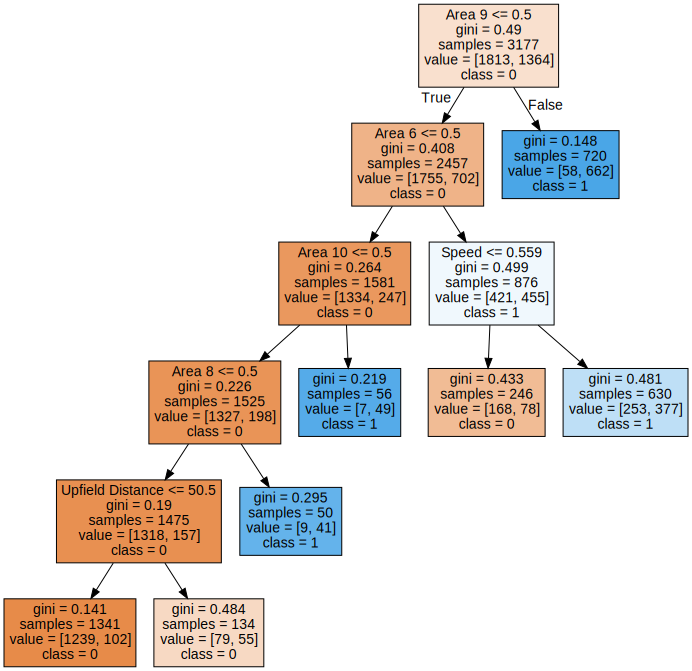

In [ ]:
# Visulaizing the Tree
features = [u'{}'.format(c) for c in X_train.columns]
classes = [u'{}'.format(c) for c in best_cdt.classes_]
dot_data = tree.export_graphviz(best_cdt, out_file=None,
                                feature_names=features,
                                class_names=classes,
                                filled=True)
graph = graphviz.Source(dot_data, format="png")
graph

### VAEP Sum

In [ ]:
# Extracting Barcelona wyID
teams[teams['name']=='Barcelona']

,city,name,wyId,officialName,area,type
15,Barcelona,Barcelona,676,FC Barcelona,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


In [ ]:
# Extracting win matches for barca
barca_win = list(matches[(matches['winner']==676)]['wyId'])

# Extracting drawn matches for barca
barca_draw = list(matches[(matches['label'].str.contains('Barcelona'))&(matches['winner']==0)]['wyId'])

# Extracting lose matches for barca
barca_lose = list(matches[(matches['label'].str.contains('Barcelona'))&(matches['winner']!=0) &(matches['winner']!=676)]['wyId'])

In [ ]:
# VAEP Calculations
d = {'short_name': ['x'], 'vaep_sum': [0], 'game_id' : [0],'opponent':[0]}
all_matches = pd.DataFrame(data=d)
players = pd.read_hdf('spadl.h5', key='players')
teams = pd.read_hdf('spadl.h5', key='teams')
all_per_game = []
for gme_id in barca_win:
  gmes = games[games['game_id']==gme_id]
  for id, game in tqdm(gmes.iterrows(), total=len(games)):

# Extracting all required data to calculate VAEP
      game_id = game['game_id']
      actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
      actions = (actions
          .merge(action_types, how='left')
          .merge(results, how='left')
          .merge(body_parts, how='left')
          .merge(players, how='left')
          .merge(teams, how='left')
          .reset_index(drop=True)
    )
      probabilities_df = pd.read_hdf('probabilities.h5', key=f'game_{game_id}')
# Calculating VAEP
      values = value(actions, probabilities_df['scores'], probabilities_df['concedes'])

# Saving all to list
      all_df = pd.concat([actions, probabilities_df, values], axis=1)
      all_per_game.append(all_df)

# transforming all to pandas dataframe
  vaep_rating = pd.concat(all_per_game)

# Aggregating the results and grouping them by player
  players_ratings = (vaep_rating[['player_id', 'team_name', 'short_name', 'vaep_value']]
      .groupby(['player_id', 'team_name', 'short_name'])
      .agg(vaep_count=('vaep_value', 'count'), vaep_sum=('vaep_value', 'sum'), vaep_mean=('vaep_value', 'mean'),)
      .sort_values('vaep_sum', ascending=False)
      .reset_index()
)
# Adding column minutes played total per player
  players_ratings = players_ratings.merge(minutes_played)

# Extracting Barca players only
  players_ratings = players_ratings[players_ratings['team_name']=='FC Barcelona']

# Extracting the required columns
  pl_per_match = players_ratings[['short_name','vaep_sum']]

  # Adding the required columns
  pl_per_match['game_id']= gme_id
  if game['home_team_id']==676:
    opponent = game['away_team_id']
  else:
    opponent = game['home_team_id']
  pl_per_match['opponent']= opponent
# Contacting each match on top of each other
  all_matches = pd.concat([all_matches, pl_per_match])

In [ ]:
# Creating table for win matches with players as columns, rows as matches and the values is total VAEP in that match
final_table_w = pd.pivot_table(all_matches, values='vaep_sum', index='game_id',
                       columns=['short_name'], aggfunc="sum")
final_table_w = final_table_w.tail(-1)
final_table_w.drop(['x'], axis = 1, inplace = True)

# Adding opponent column and Win as status
opps = []
for i in final_table_w.index:
  mattche = all_matches[all_matches['game_id']==i]
  opp = mattche['opponent'].iloc[0]
  opps.append(opp)
final_table_w['opponent']=opps
final_table_w['Status']='Win'

In [ ]:
# VAEP Calculations
d = {'short_name': ['x'], 'vaep_sum': [0], 'game_id' : [0],'opponent':[0]}
all_matches = pd.DataFrame(data=d)
players = pd.read_hdf('spadl.h5', key='players')
teams = pd.read_hdf('spadl.h5', key='teams')
all_per_game = []
for gme_id in barca_lose:
  gmes = games[games['game_id']==gme_id]
  for id, game in tqdm(gmes.iterrows(), total=len(games)):

# Extracting all required data to calculate VAEP
      game_id = game['game_id']
      actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
      actions = (actions
          .merge(action_types, how='left')
          .merge(results, how='left')
          .merge(body_parts, how='left')
          .merge(players, how='left')
          .merge(teams, how='left')
          .reset_index(drop=True)
    )
      probabilities_df = pd.read_hdf('probabilities.h5', key=f'game_{game_id}')
# Calculating VAEP
      values = value(actions, probabilities_df['scores'], probabilities_df['concedes'])

# Saving all to list
      all_df = pd.concat([actions, probabilities_df, values], axis=1)
      all_per_game.append(all_df)

# transforming all to pandas dataframe
  vaep_rating = pd.concat(all_per_game)

# Aggregating the results and grouping them by player
  players_ratings = (vaep_rating[['player_id', 'team_name', 'short_name', 'vaep_value']]
      .groupby(['player_id', 'team_name', 'short_name'])
      .agg(vaep_count=('vaep_value', 'count'), vaep_sum=('vaep_value', 'sum'), vaep_mean=('vaep_value', 'mean'),)
      .sort_values('vaep_sum', ascending=False)
      .reset_index()
)
# Adding column minutes played total per player
  players_ratings = players_ratings.merge(minutes_played)

# Extracting Barca players only
  players_ratings = players_ratings[players_ratings['team_name']=='FC Barcelona']

# Extracting the required columns
  pl_per_match = players_ratings[['short_name','vaep_sum']]

  # Adding the required columns
  pl_per_match['game_id']= gme_id
  if game['home_team_id']==676:
    opponent = game['away_team_id']
  else:
    opponent = game['home_team_id']
  pl_per_match['opponent']= opponent
# Contacting each match on top of each other
  all_matches = pd.concat([all_matches, pl_per_match])

In [ ]:
# Creating table for lose matches with players as columns, rows as matches and the values is total VAEP in that match
final_table_l = pd.pivot_table(all_matches, values='vaep_sum', index='game_id',
                       columns=['short_name'], aggfunc="sum")
final_table_l = final_table_l.tail(-1)
final_table_l.drop(['x'], axis = 1, inplace = True)

# Adding opponent column and Lose as status
opps = []
for i in final_table_l.index:
  mattche = all_matches[all_matches['game_id']==i]
  opp = mattche['opponent'].iloc[0]
  opps.append(opp)
final_table_l['opponent']=opps
final_table_l['Status']='Lose'

In [ ]:
# VAEP Calculations
d = {'short_name': ['x'], 'vaep_sum': [0], 'game_id' : [0],'opponent':[0]}
all_matches = pd.DataFrame(data=d)
players = pd.read_hdf('spadl.h5', key='players')
teams = pd.read_hdf('spadl.h5', key='teams')
all_per_game = []
for gme_id in barca_draw:
  gmes = games[games['game_id']==gme_id]
  for id, game in tqdm(gmes.iterrows(), total=len(games)):

# Extracting all required data to calculate VAEP
      game_id = game['game_id']
      actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
      actions = (actions
          .merge(action_types, how='left')
          .merge(results, how='left')
          .merge(body_parts, how='left')
          .merge(players, how='left')
          .merge(teams, how='left')
          .reset_index(drop=True)
    )
      probabilities_df = pd.read_hdf('probabilities.h5', key=f'game_{game_id}')
# Calculating VAEP
      values = value(actions, probabilities_df['scores'], probabilities_df['concedes'])

# Saving all to list
      all_df = pd.concat([actions, probabilities_df, values], axis=1)
      all_per_game.append(all_df)

# transforming all to pandas dataframe
  vaep_rating = pd.concat(all_per_game)

# Aggregating the results and grouping them by player
  players_ratings = (vaep_rating[['player_id', 'team_name', 'short_name', 'vaep_value']]
      .groupby(['player_id', 'team_name', 'short_name'])
      .agg(vaep_count=('vaep_value', 'count'), vaep_sum=('vaep_value', 'sum'), vaep_mean=('vaep_value', 'mean'),)
      .sort_values('vaep_sum', ascending=False)
      .reset_index()
)
# Adding column minutes played total per player
  players_ratings = players_ratings.merge(minutes_played)

# Extracting Barca players only
  players_ratings = players_ratings[players_ratings['team_name']=='FC Barcelona']

# Extracting the required columns
  pl_per_match = players_ratings[['short_name','vaep_sum']]

  # Adding the required columns
  pl_per_match['game_id']= gme_id
  if game['home_team_id']==676:
    opponent = game['away_team_id']
  else:
    opponent = game['home_team_id']
  pl_per_match['opponent']= opponent
# Contacting each match on top of each other
  all_matches = pd.concat([all_matches, pl_per_match])

In [ ]:
# Creating table for draw matches with players as columns, rows as matches and the values is total VAEP in that match
final_table_d = pd.pivot_table(all_matches, values='vaep_sum', index='game_id',
                       columns=['short_name'], aggfunc="sum")
final_table_d = final_table_d.tail(-1)
final_table_d.drop(['x'], axis = 1, inplace = True)

# Adding opponent column and Draw as status
opps = []
for i in final_table_d.index:
  mattche = all_matches[all_matches['game_id']==i]
  opp = mattche['opponent'].iloc[0]
  opps.append(opp)
final_table_d['opponent']=opps
final_table_d['Status']='Draw'

In [ ]:
# Adding all 3 together
barca_sum_vaep = pd.concat([final_table_w,final_table_l])
barca_sum_vaep = pd.concat([barca_sum_vaep,final_table_d])

In [ ]:
# Swapping opponent by their strength in table
top_5 = ['Villarreal','Real Madrid', 'Barcelona', 'Atlético Madrid','Valencia']
top_middle = ['Sevilla', 'Real Betis','Getafe','Eibar','Girona']
bottom_middle = ['Real Sociedad','Celta de Vigo','Espanyol','Levante','Deportivo Alavés']
team_rank=[]
for id,row in barca_sum_vaep.iterrows():
  name = teams[teams['team_id']==row.opponent].iloc[0]['short_team_name']
  if name in top_5:
    team_rank.append(1)
  elif name in top_middle:
    team_rank.append(2)
  elif name in bottom_middle:
    team_rank.append(3)
  else:
    team_rank.append(4)
barca_sum_vaep['Strengh'] = team_rank
barca_sum_vaep.drop('opponent',axis=1,inplace=True)

In [ ]:
# Filling NaN with 0 (no contribution)
barca_sum_vaep = barca_sum_vaep.fillna(0)

# Vizualising final table
barca_sum_vaep

short_name,Aleix Vidal,André Gomes,Denis Suárez,Deulofeu,I. Rakitić,Iniesta,J. Cillessen,J. Mascherano,Jordi Alba,José Arnáiz,...,Paulinho,Philippe Coutinho,Piqué,S. Umtiti,Sergi Roberto,Sergio Busquets,T. Vermaelen,Y. Mina,Status,Strengh
game_id,,,,,,,,,,,,,,,,,,,,,
2565554,0.572025,0.219776,2.601190,0.119468,9.179316,5.318649,0.433197,2.435123,5.277331,0.046268,...,5.935104,5.032883,4.947983,4.129737,6.149248,5.875954,1.174418,0.407638,Win,2
2565559,0.719641,0.219776,2.594685,0.362097,8.933780,5.318649,0.433197,2.081452,5.309391,0.046268,...,5.935104,5.032883,4.947983,3.803102,5.655771,5.518475,1.174418,0.407638,Win,3
2565577,0.865209,0.219776,2.673386,0.578723,8.711891,5.083739,0.433197,2.081452,5.670855,0.046268,...,5.924971,5.032883,4.751953,3.716388,5.180278,4.973272,1.174418,0.407638,Win,3
2565580,0.865209,-0.016997,2.673386,0.401313,8.232401,4.772776,0.433197,2.081452,4.840007,0.046268,...,6.090881,5.032883,3.730943,3.756688,5.180278,4.863236,1.174418,0.407638,Win,2
2565592,0.865209,-0.016997,1.861308,0.419085,7.557587,4.634631,0.433197,2.081452,4.731411,0.046268,...,5.167102,5.032883,3.546573,3.290407,4.865491,4.742387,1.174418,0.407638,Win,2
2565603,0.738898,-0.016997,0.600358,0.730556,7.457303,4.130980,0.433197,1.655886,4.731411,0.046268,...,4.333701,5.032883,3.127787,3.290407,4.780756,4.583810,1.174418,0.407638,Win,2
2565615,0.785123,-0.103288,0.591333,0.730556,7.360323,3.939373,0.433197,1.399022,4.693141,0.046268,...,4.150672,5.032883,3.127787,3.145795,5.019090,4.570027,1.174418,0.407638,Win,4
2565629,0.780751,-0.102095,-0.015620,0.730556,7.196450,3.973664,0.433197,1.334831,4.574236,0.046268,...,4.294101,5.032883,3.216589,3.145795,4.270230,3.718578,1.174418,0.407638,Win,4
2565647,0.780751,-0.102095,-0.015620,0.252086,7.128535,2.894138,0.433197,0.794765,4.574236,0.046268,...,4.708736,5.032883,3.216589,2.903026,3.694544,3.627981,1.174418,0.407638,Win,4


In [ ]:
# Dividing the data in train and test subsets
y = barca_sum_vaep.Status
X = barca_sum_vaep.drop('Status', axis=1)

In [ ]:
# Training the first model
cdt = tree.DecisionTreeClassifier()
cdt.fit(X, y)
y_pred = cdt.predict(X)
accuracy_score(y,y_pred)

1.0

In [ ]:
# Saving the Tree
features = [u'{}'.format(c) for c in X.columns]
classes = [u'{}'.format(c) for c in cdt.classes_]
dot_data = StringIO()
tree.export_graphviz(cdt, out_file=dot_data,
                                feature_names=features,
                                class_names=classes,
                                filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('/content/drive/MyDrive/thesis/La Liga/Barca_VAEP_Sum.png')

True

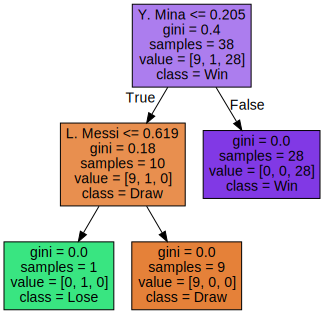

In [ ]:
# Visulaizing the Tree
features = [u'{}'.format(c) for c in X.columns]
classes = [u'{}'.format(c) for c in cdt.classes_]
dot_data = tree.export_graphviz(cdt, out_file=None,
                                feature_names=features,
                                class_names=classes,
                                filled=True)
graph = graphviz.Source(dot_data, format="png")
graph

### XThreat

In [ ]:
# Extracting win matches for barca away
barca_win_away = list(matches[(matches['winner']==676)&(matches['venue']!='Camp Nou')]['wyId'])
gmes = games[games['game_id'].isin(barca_win_away)]

In [ ]:
# Extracting the necessary features
A = []
for id, game in tqdm(gmes.iterrows(), total=len(gmes)):

# Extracting Events data from SPAL format
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    A.append(actions)
A = pd.concat(A)
# Getting the xthreat model
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(A)

  0%|          | 0/12 [00:00<?, ?it/s]

# iterations:  35


<ipython-input-78-a008bc0b324e>:5: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


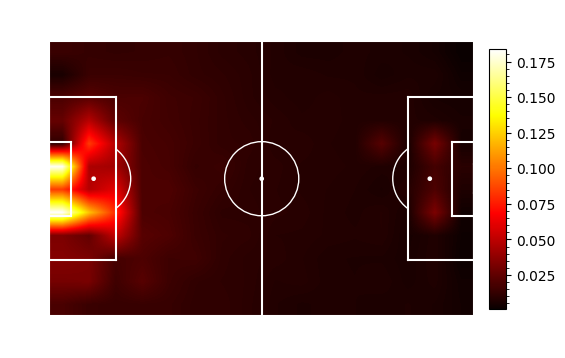

<Axes: >

In [ ]:
# Inspect the interpolated heatmap used for predictions
interp = xTModel.interpolator()
x = np.linspace(0, 105, 1050)
y = np.linspace(0, 68, 680)
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")

In [ ]:
# Extracting win matches for barca home
barca_win_home = list(matches[(matches['winner']==676)&(matches['venue']=='Camp Nou')]['wyId'])
gmes = games[games['game_id'].isin(barca_win_home)]

In [ ]:
# Extracting the necessary features
A = []
for id, game in tqdm(gmes.iterrows(), total=len(gmes)):

# Extracting Events data from SPAL format
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    A.append(actions)
A = pd.concat(A)
# Getting the xthreat model
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(A)

  0%|          | 0/16 [00:00<?, ?it/s]

# iterations:  38


<ipython-input-81-a008bc0b324e>:5: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


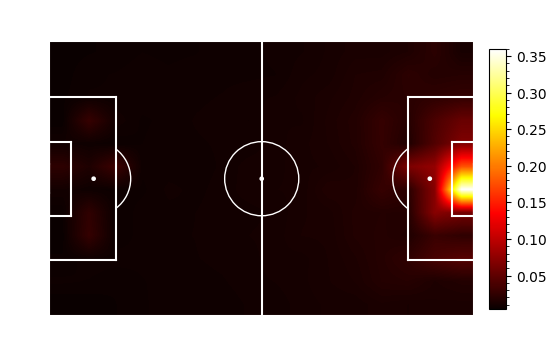

<Axes: >

In [ ]:
# Inspect the interpolated heatmap used for predictions
interp = xTModel.interpolator()
x = np.linspace(0, 105, 1050)
y = np.linspace(0, 68, 680)
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")

In [ ]:
# Extracting drawn matches for barca
barca_draw_home = list(matches[(matches['label'].str.contains('Barcelona'))&(matches['winner']==0)&(matches['venue']=='Camp Nou')]['wyId'])
gmes = games[games['game_id'].isin(barca_draw_home)]

In [ ]:
# Extracting the necessary features
A = []
for id, game in tqdm(gmes.iterrows(), total=len(gmes)):

# Extracting Events data from SPAL format
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    A.append(actions)
A = pd.concat(A)
# Getting the xthreat model
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(A)

  0%|          | 0/3 [00:00<?, ?it/s]

# iterations:  38


<ipython-input-86-a008bc0b324e>:5: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


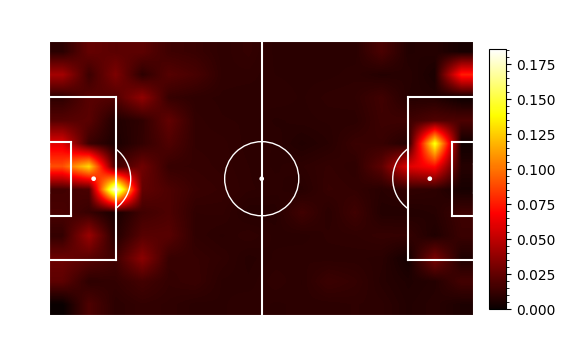

<Axes: >

In [ ]:
# Inspect the interpolated heatmap used for predictions
interp = xTModel.interpolator()
x = np.linspace(0, 105, 1050)
y = np.linspace(0, 68, 680)
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")

In [ ]:
# Extracting drawn matches for barca
barca_draw_away = list(matches[(matches['label'].str.contains('Barcelona'))&(matches['winner']==0)&(matches['venue']!='Camp Nou')]['wyId'])
gmes = games[games['game_id'].isin(barca_draw_away)]

In [ ]:
# Extracting the necessary features
A = []
for id, game in tqdm(gmes.iterrows(), total=len(gmes)):

# Extracting Events data from SPAL format
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    A.append(actions)
A = pd.concat(A)
# Getting the xthreat model
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(A)

  0%|          | 0/6 [00:00<?, ?it/s]

# iterations:  32


<ipython-input-89-a008bc0b324e>:5: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


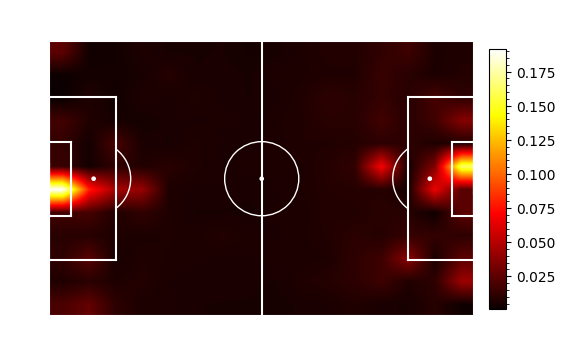

<Axes: >

In [ ]:
# Inspect the interpolated heatmap used for predictions
interp = xTModel.interpolator()
x = np.linspace(0, 105, 1050)
y = np.linspace(0, 68, 680)
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")

In [ ]:
# Extracting lose matches for barca
barca_lose = list(matches[(matches['label'].str.contains('Barcelona'))&(matches['winner']!=0) &(matches['winner']!=676)]['wyId'])
gmes = games[games['game_id'].isin(barca_lose)]

In [ ]:
# Extracting the necessary features
A = []
for id, game in tqdm(gmes.iterrows(), total=len(gmes)):

# Extracting Events data from SPAL format
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    A.append(actions)
A = pd.concat(A)
# Getting the xthreat model
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(A)

  0%|          | 0/1 [00:00<?, ?it/s]

# iterations:  39


<ipython-input-92-a008bc0b324e>:5: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


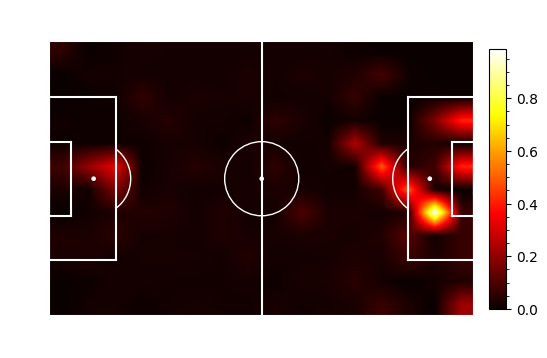

<Axes: >

In [ ]:
# Inspect the interpolated heatmap used for predictions
interp = xTModel.interpolator()
x = np.linspace(0, 105, 1050)
y = np.linspace(0, 68, 680)
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")

## Real Madrid

### Sequence Analysis

In [ ]:
# Changing the status from win to lose for barca win against madrid
def change_outcome(row):
  if row.matchId == 2565711:
    outcome = 'Lose'
  else:
    outcome = row.Outcome
  return outcome
Liga_analyis['Outcome'] = Liga_analyis.apply(change_outcome,axis=1)

In [ ]:
# Filtering and getting only real madrid events in their win matches
real_events = Liga_analyis[Liga_analyis['Name']=='Real Madrid']
real_win_events = real_events[real_events['Outcome']=='Win']
print(real_win_events.matchId.nunique())

22


In [ ]:
# Saving the seperate parts in separates csv
match_rank = real_win_events['Match Rank'].unique()
success = real_win_events['Successful'].unique()
for i in match_rank:
  df  = real_win_events[real_win_events['Match Rank']== i]
  for num in success:
    sub_df = df[df['Successful']==num]
    if num==1:
      path = '/content/drive/MyDrive/thesis/La Liga/Real Madrid/Real win'+ i+' Success.csv'
    else:
      path = '/content/drive/MyDrive/thesis/La Liga/Real Madrid/Real win'+ i+' Unsuccess.csv'
    sub_df.to_csv(path,index=False)

In [ ]:
# Filtering and getting only real madrid events in their draw matches
real_draw_events = real_events[real_events['Outcome']=='Draw']
print(real_draw_events.matchId.nunique())

10


In [45]:
real_draw_events['Match Rank'].unique()

array(['Top 5 vs Top 5', 'Top 5 vs Bottom Middle 5', 'Top 5 vs Bottom 5'],
      dtype=object)

In [ ]:
# Saving the seperate parts in separates csv
match_rank = real_draw_events['Match Rank'].unique()
success = real_draw_events['Successful'].unique()
for i in match_rank:
  df  = real_draw_events[real_draw_events['Match Rank']== i]
  for num in success:
    sub_df = df[df['Successful']==num]
    if num==1:
      path = '/content/drive/MyDrive/thesis/La Liga/Real Madrid/Real draw'+ i+' Success.csv'
    else:
      path = '/content/drive/MyDrive/thesis/La Liga/Real Madrid/Real draw'+ i+' Unsuccess.csv'
    sub_df.to_csv(path,index=False)

In [ ]:
# Filtering and getting only real madrid events in their lose matches
real_lose_events = real_events[real_events['Outcome']=='Lose']
print(real_lose_events.matchId.nunique())

6


In [ ]:
# Saving the seperate parts in separates csv
match_rank = real_lose_events['Match Rank'].unique()
success = real_lose_events['Successful'].unique()
for i in match_rank:
  df  = real_lose_events[real_lose_events['Match Rank']== i]
  for num in success:
    sub_df = df[df['Successful']==num]
    if num==1:
      path = '/content/drive/MyDrive/thesis/La Liga/Real Madrid/Real lose'+ i+' Success.csv'
    else:
      path = '/content/drive/MyDrive/thesis/La Liga/Real Madrid/Real lose'+ i+' Unsuccess.csv'
    sub_df.to_csv(path,index=False)

### Decision tree

In [ ]:
# Dividing the data in train and test subsets
perform_encoded_b = perform_encoded[perform_encoded['Name']=='Real Madrid']
y = perform_encoded_b.Successful
X = perform_encoded_b.drop(['Successful','Sequence','Name'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Training the first model
cdt = tree.DecisionTreeClassifier()
cdt.fit(X_train, y_train)
y_pred = cdt.predict(X_test)
accuracy_score(y_test,y_pred)

0.8043202033036849

In [ ]:
# Extracting the alphas to prune the tree to reduce complexcity
alphas = cdt.cost_complexity_pruning_path(X_train, y_train)['ccp_alphas']

In [ ]:
# Getting the best alpha that prunes that tree without sacrificing the accuracy
param_grid = [{
    'ccp_alpha': alphas}]
dt = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(dt, param_grid,scoring='accuracy',cv=3)
grid_search.fit(X_train,y_train)
best_parameters = grid_search.best_params_
score = grid_search.best_score_

In [ ]:
# Displaying the best parameters with its score
print(best_parameters)
print(score)

{'ccp_alpha': 0.0033767124993874832}
0.8225190839694655


In [ ]:
# Extracting the best model and testing it with test subset
best_cdt = grid_search.best_estimator_
y_pred = best_cdt.predict(X_test)
accuracy_score(y_test,y_pred)

0.8119440914866582

In [ ]:
# Saving the Tree
features = [u'{}'.format(c) for c in X_train.columns]
classes = [u'{}'.format(c) for c in best_cdt.classes_]
dot_data = StringIO()
tree.export_graphviz(best_cdt, out_file=dot_data,
                                feature_names=features,
                                class_names=classes,
                                filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('/content/drive/MyDrive/thesis/La Liga/Madrid_DT.png')

True

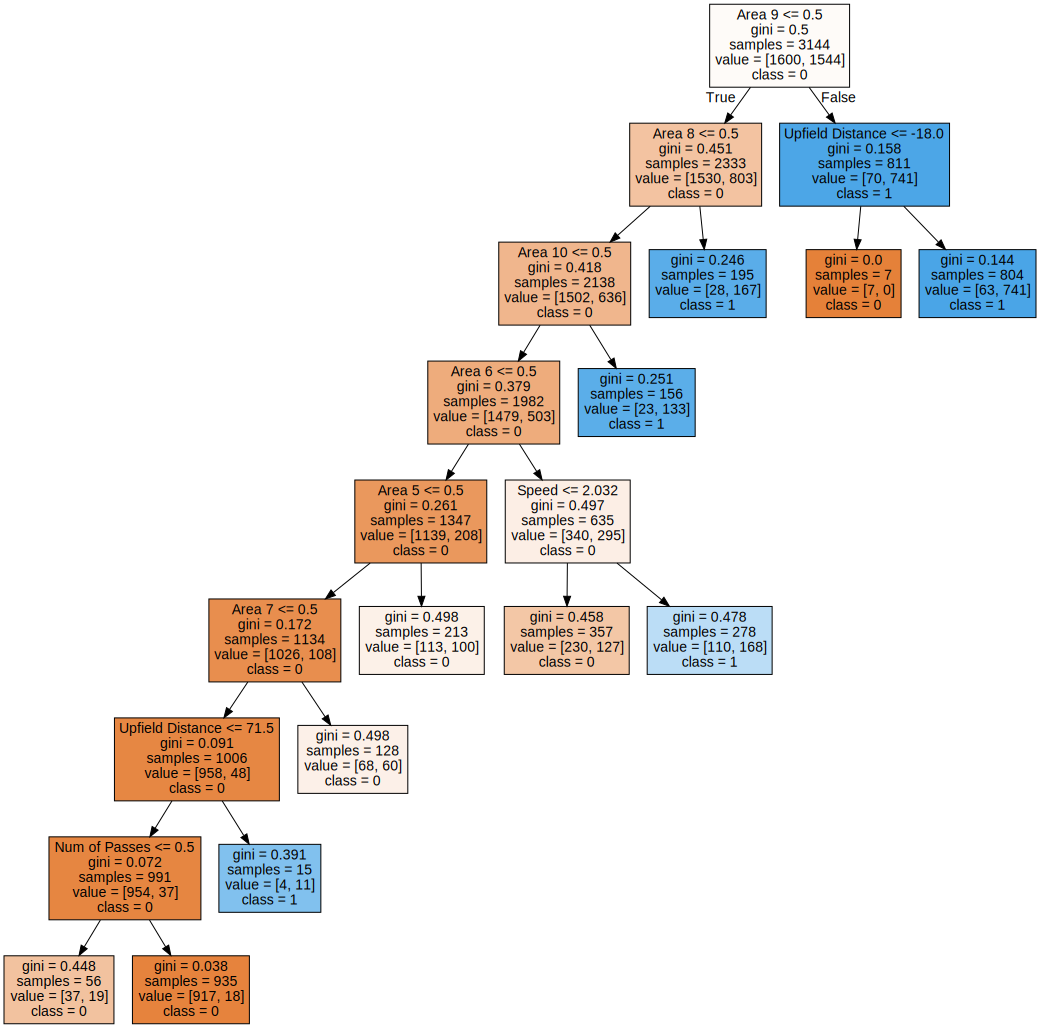

In [ ]:
# Visulaizing the Tree
features = [u'{}'.format(c) for c in X_train.columns]
classes = [u'{}'.format(c) for c in best_cdt.classes_]
dot_data = tree.export_graphviz(best_cdt, out_file=None,
                                feature_names=features,
                                class_names=classes,
                                filled=True)
graph = graphviz.Source(dot_data, format="png")
graph

### VAEP Sum

In [ ]:
# Extracting Barcelona wyID
teams[teams['name']=='Real Madrid']

,city,name,wyId,officialName,area,type
14,Madrid,Real Madrid,675,Real Madrid Club de Fútbol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


In [ ]:
# Extracting win matches for Real Madrid
real_win = list(matches[(matches['winner']==675)]['wyId'])

# Extracting drawn matches for Real Madrid
real_draw = list(matches[(matches['label'].str.contains('Real Madrid'))&(matches['winner']==0)]['wyId'])

# Extracting lose matches for Real Madrid
real_lose = list(matches[(matches['label'].str.contains('Real Madrid'))&(matches['winner']!=0) &(matches['winner']!=675)]['wyId'])

In [ ]:
# VAEP Calculations
d = {'short_name': ['x'], 'vaep_sum': [0], 'game_id' : [0],'opponent':[0]}
all_matches = pd.DataFrame(data=d)
players = pd.read_hdf('spadl.h5', key='players')
teams = pd.read_hdf('spadl.h5', key='teams')
all_per_game = []
for gme_id in real_win:
  gmes = games[games['game_id']==gme_id]
  for id, game in tqdm(gmes.iterrows(), total=len(games)):
# Extracting all required data to calculate VAEP
      game_id = game['game_id']
      actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
      actions = (actions
          .merge(action_types, how='left')
          .merge(results, how='left')
          .merge(body_parts, how='left')
          .merge(players, how='left')
          .merge(teams, how='left')
          .reset_index(drop=True)
    )
      probabilities_df = pd.read_hdf('probabilities.h5', key=f'game_{game_id}')
# Calculating VAEP
      values = value(actions, probabilities_df['scores'], probabilities_df['concedes'])

# Saving all to list
      all_df = pd.concat([actions, probabilities_df, values], axis=1)
      all_per_game.append(all_df)

# transforming all to pandas dataframe
  vaep_rating = pd.concat(all_per_game)

# Aggregating the results and grouping them by player
  players_ratings = (vaep_rating[['player_id', 'team_name', 'short_name', 'vaep_value']]
      .groupby(['player_id', 'team_name', 'short_name'])
      .agg(vaep_count=('vaep_value', 'count'), vaep_sum=('vaep_value', 'sum'), vaep_mean=('vaep_value', 'mean'),)
      .sort_values('vaep_sum', ascending=False)
      .reset_index()
)
# Adding column minutes played total per player
  players_ratings = players_ratings.merge(minutes_played)
# Extracting Barca players only
  players_ratings = players_ratings[players_ratings['team_name']=='Real Madrid Club de Fútbol']

# Extracting the required columns
  pl_per_match = players_ratings[['short_name','vaep_sum','team_name']]

  # Adding the required columns
  pl_per_match['game_id']= gme_id
  if game['home_team_id']==675:
    opponent = game['away_team_id']
  else:
    opponent = game['home_team_id']
  pl_per_match['opponent']= opponent
# Contacting each match on top of each other
  all_matches = pd.concat([all_matches, pl_per_match])

In [ ]:
# Creating table for win matches with players as columns, rows as matches and the values is total VAEP in that match
final_table_w = pd.pivot_table(all_matches, values='vaep_sum', index='game_id',
                       columns=['short_name'], aggfunc="sum")
final_table_w = final_table_w.tail(-1)
final_table_w.drop(['x'], axis = 1, inplace = True)

# Adding opponent column and Win as status
opps = []
for i in final_table_w.index:
  mattche = all_matches[all_matches['game_id']==i]
  opp = mattche['opponent'].iloc[0]
  opps.append(opp)
final_table_w['opponent']=opps
final_table_w['Status']='Win'

In [ ]:
# VAEP Calculations
d = {'short_name': ['x'], 'vaep_sum': [0], 'game_id' : [0],'opponent':[0]}
all_matches = pd.DataFrame(data=d)
players = pd.read_hdf('spadl.h5', key='players')
teams = pd.read_hdf('spadl.h5', key='teams')
all_per_game = []
for gme_id in real_lose:
  gmes = games[games['game_id']==gme_id]
  for id, game in tqdm(gmes.iterrows(), total=len(games)):

# Extracting all required data to calculate VAEP
      game_id = game['game_id']
      actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
      actions = (actions
          .merge(action_types, how='left')
          .merge(results, how='left')
          .merge(body_parts, how='left')
          .merge(players, how='left')
          .merge(teams, how='left')
          .reset_index(drop=True)
    )
      probabilities_df = pd.read_hdf('probabilities.h5', key=f'game_{game_id}')
# Calculating VAEP
      values = value(actions, probabilities_df['scores'], probabilities_df['concedes'])

# Saving all to list
      all_df = pd.concat([actions, probabilities_df, values], axis=1)
      all_per_game.append(all_df)

# transforming all to pandas dataframe
  vaep_rating = pd.concat(all_per_game)

# Aggregating the results and grouping them by player
  players_ratings = (vaep_rating[['player_id', 'team_name', 'short_name', 'vaep_value']]
      .groupby(['player_id', 'team_name', 'short_name'])
      .agg(vaep_count=('vaep_value', 'count'), vaep_sum=('vaep_value', 'sum'), vaep_mean=('vaep_value', 'mean'),)
      .sort_values('vaep_sum', ascending=False)
      .reset_index()
)
# Adding column minutes played total per player
  players_ratings = players_ratings.merge(minutes_played)

# Extracting Barca players only
  players_ratings = players_ratings[players_ratings['team_name']=='Real Madrid Club de Fútbol']

# Extracting the required columns
  pl_per_match = players_ratings[['short_name','vaep_sum']]

  # Adding the required columns
  pl_per_match['game_id']= gme_id
  if game['home_team_id']==675:
    opponent = game['away_team_id']
  else:
    opponent = game['home_team_id']
  pl_per_match['opponent']= opponent
# Contacting each match on top of each other
  all_matches = pd.concat([all_matches, pl_per_match])

In [ ]:
# Creating table for lose matches with players as columns, rows as matches and the values is total VAEP in that match
final_table_l = pd.pivot_table(all_matches, values='vaep_sum', index='game_id',
                       columns=['short_name'], aggfunc="sum")
final_table_l = final_table_l.tail(-1)
final_table_l.drop(['x'], axis = 1, inplace = True)

# Adding opponent column and Lose as status
opps = []
for i in final_table_l.index:
  mattche = all_matches[all_matches['game_id']==i]
  opp = mattche['opponent'].iloc[0]
  opps.append(opp)
final_table_l['opponent']=opps
final_table_l['Status']='Lose'

In [ ]:
# VAEP Calculations
d = {'short_name': ['x'], 'vaep_sum': [0], 'game_id' : [0],'opponent':[0]}
all_matches = pd.DataFrame(data=d)
players = pd.read_hdf('spadl.h5', key='players')
teams = pd.read_hdf('spadl.h5', key='teams')
all_per_game = []
for gme_id in real_draw:
  gmes = games[games['game_id']==gme_id]
  for id, game in tqdm(gmes.iterrows(), total=len(games)):

# Extracting all required data to calculate VAEP
      game_id = game['game_id']
      actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
      actions = (actions
          .merge(action_types, how='left')
          .merge(results, how='left')
          .merge(body_parts, how='left')
          .merge(players, how='left')
          .merge(teams, how='left')
          .reset_index(drop=True)
    )
      probabilities_df = pd.read_hdf('probabilities.h5', key=f'game_{game_id}')
# Calculating VAEP
      values = value(actions, probabilities_df['scores'], probabilities_df['concedes'])

# Saving all to list
      all_df = pd.concat([actions, probabilities_df, values], axis=1)
      all_per_game.append(all_df)

# transforming all to pandas dataframe
  vaep_rating = pd.concat(all_per_game)

# Aggregating the results and grouping them by player
  players_ratings = (vaep_rating[['player_id', 'team_name', 'short_name', 'vaep_value']]
      .groupby(['player_id', 'team_name', 'short_name'])
      .agg(vaep_count=('vaep_value', 'count'), vaep_sum=('vaep_value', 'sum'), vaep_mean=('vaep_value', 'mean'),)
      .sort_values('vaep_sum', ascending=False)
      .reset_index()
)
# Adding column minutes played total per player
  players_ratings = players_ratings.merge(minutes_played)

# Extracting Barca players only
  players_ratings = players_ratings[players_ratings['team_name']=='Real Madrid Club de Fútbol']

# Extracting the required columns
  pl_per_match = players_ratings[['short_name','vaep_sum']]

  # Adding the required columns
  pl_per_match['game_id']= gme_id
  if game['home_team_id']==675:
    opponent = game['away_team_id']
  else:
    opponent = game['home_team_id']
  pl_per_match['opponent']= opponent
# Contacting each match on top of each other
  all_matches = pd.concat([all_matches, pl_per_match])

In [ ]:
# Creating table for draw matches with players as columns, rows as matches and the values is total VAEP in that match
final_table_d = pd.pivot_table(all_matches, values='vaep_sum', index='game_id',
                       columns=['short_name'], aggfunc="sum")
final_table_d = final_table_d.tail(-1)
final_table_d.drop(['x'], axis = 1, inplace = True)

# Adding opponent column and Draw as status
opps = []
for i in final_table_d.index:
  mattche = all_matches[all_matches['game_id']==i]
  opp = mattche['opponent'].iloc[0]
  opps.append(opp)
final_table_d['opponent']=opps
final_table_d['Status']='Draw'

In [ ]:
# Adding all 3 together
real_sum_vaep = pd.concat([final_table_w,final_table_l])
real_sum_vaep = pd.concat([real_sum_vaep,final_table_d])

In [ ]:
# Swapping opponent by their strength in table
top_5 = ['Villarreal','Real Madrid', 'Barcelona', 'Atlético Madrid','Valencia']
top_middle = ['Sevilla', 'Real Betis','Getafe','Eibar','Girona']
bottom_middle = ['Real Sociedad','Celta de Vigo','Espanyol','Levante','Deportivo Alavés']
team_rank=[]
for id,row in barca_sum_vaep.iterrows():
  name = teams[teams['team_id']==row.opponent].iloc[0]['short_team_name']
  if name in top_5:
    team_rank.append(1)
  elif name in top_middle:
    team_rank.append(2)
  elif name in bottom_middle:
    team_rank.append(3)
  else:
    team_rank.append(4)
real_sum_vaep['Strengh'] = team_rank
real_sum_vaep.drop('opponent',axis=1,inplace=True)

In [ ]:
# Filling NaN with 0 (no contribution)
real_sum_vaep = real_sum_vaep.fillna(0)

# Vizualising final table
real_sum_vaep

short_name,A. Hakimi,Borja Mayoral,Casemiro,Cristiano Ronaldo,Dani Ceballos,Daniel Carvajal,G. Bale,Isco,Jesús Vallejo,K. Benzema,...,Marco Asensio,Marcos Llorente,Nacho,R. Varane,Sergio Ramos,T. Hernández,T. Kroos,Status,L. Zidane,Strengh
game_id,,,,,,,,,,,,,,,,,,,,,
2565555,2.505146,0.404196,6.579074,10.414449,2.735943,2.635246,7.680743,6.355899,0.784880,-0.632886,...,4.881130,0.205244,2.434454,3.053598,4.954179,1.885621,10.025218,Win,0.000000,2
2565583,2.505146,0.404196,5.806881,10.414449,2.735943,2.634135,7.836686,6.391210,0.784880,-0.940336,...,4.719702,0.193984,2.327633,3.053598,4.713338,1.885621,8.873492,Win,0.000000,3
2565598,2.505146,-0.278570,5.539651,10.414449,2.724800,2.419308,6.936560,6.156746,0.784880,-0.940336,...,4.918241,0.193984,2.322680,3.064685,4.241984,1.544047,8.873492,Win,0.000000,3
2565609,2.505146,-0.300858,5.200913,10.530780,0.821696,2.312639,6.936560,6.035145,0.784880,-0.940336,...,4.593769,0.249231,2.252807,2.876430,4.016166,1.544047,8.873492,Win,0.000000,2
2565619,2.413719,-0.291046,5.033472,10.396474,0.844759,2.312639,6.936560,3.477920,0.784880,-0.940336,...,4.380010,0.249231,2.189653,2.767600,3.701606,1.544047,8.812533,Win,0.000000,2
2565633,2.209944,-0.377703,5.033472,9.809598,0.844759,2.312639,6.936560,3.323221,0.784880,-1.453629,...,4.344626,0.203361,1.798764,2.767600,3.267008,1.655722,8.581039,Win,0.000000,2
2565657,2.209944,-0.377703,4.712763,10.097714,0.742795,2.312639,6.936560,3.251937,0.784880,-1.389454,...,3.487631,0.203361,1.635198,2.322068,2.963879,1.474533,8.581039,Win,0.000000,4
2565673,2.209944,-0.377703,3.715854,10.420677,0.669771,2.312639,6.936560,2.641923,0.429774,-1.287970,...,2.724478,0.014282,1.983736,2.322068,2.100337,1.474533,8.075611,Win,0.000000,4
2565695,2.209944,-0.404877,2.909309,9.623343,0.669771,2.199509,6.936560,2.691792,0.371527,-1.475650,...,2.724478,0.014282,1.983736,2.102352,2.100337,1.542447,7.578332,Win,0.000000,4


In [ ]:
# Dividing the data in train and test subsets
y = real_sum_vaep.Status
X = real_sum_vaep.drop('Status', axis=1)

In [ ]:
# Training the first model
cdt = tree.DecisionTreeClassifier()
cdt.fit(X, y)
y_pred = cdt.predict(X)
accuracy_score(y,y_pred)

1.0

In [ ]:
# Saving the Tree
features = [u'{}'.format(c) for c in X.columns]
classes = [u'{}'.format(c) for c in cdt.classes_]
dot_data = StringIO()
tree.export_graphviz(cdt, out_file=dot_data,
                                feature_names=features,
                                class_names=classes,
                                filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('/content/drive/MyDrive/thesis/La Liga/Real_VAEP_Sum.png')

True

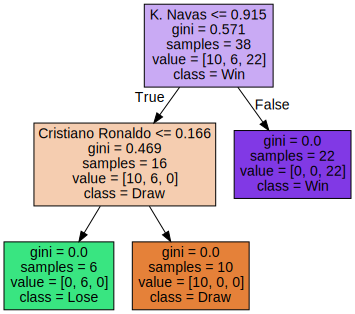

In [ ]:
# Visulaizing the Tree
features = [u'{}'.format(c) for c in X.columns]
classes = [u'{}'.format(c) for c in cdt.classes_]
dot_data = tree.export_graphviz(cdt, out_file=None,
                                feature_names=features,
                                class_names=classes,
                                filled=True)
graph = graphviz.Source(dot_data, format="png")
graph

### XThreat

In [ ]:
# Extracting win matches for Real Madrid
real_win_home = list(matches[(matches['winner']==675)&(matches['venue']=='Estadio Santiago Bernabéu')]['wyId'])
gmes = games[games['game_id'].isin(real_win_home)]

In [ ]:
# Extracting the necessary features
A = []
for id, game in tqdm(gmes.iterrows(), total=len(gmes)):

# Extracting Events data from SPAL format
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    A.append(actions)
A = pd.concat(A)
# Getting the xthreat model
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(A)

  0%|          | 0/12 [00:00<?, ?it/s]

# iterations:  44


<ipython-input-100-a008bc0b324e>:5: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


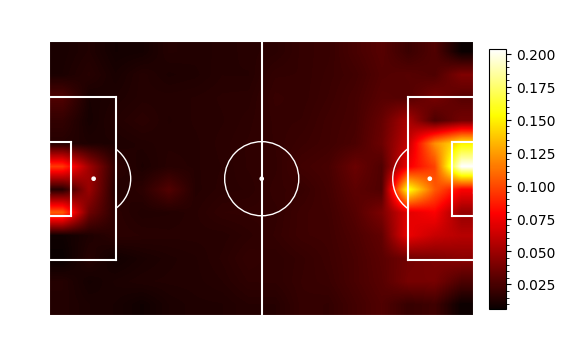

<Axes: >

In [ ]:
# Inspect the interpolated heatmap used for predictions
interp = xTModel.interpolator()
x = np.linspace(0, 105, 1050)
y = np.linspace(0, 68, 680)
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")

In [ ]:
# Extracting win matches for Real Madrid
real_win_away = list(matches[(matches['winner']==675)&(matches['venue']!='Estadio Santiago Bernabéu')]['wyId'])
gmes = games[games['game_id'].isin(real_win_away)]

In [ ]:
# Extracting the necessary features
A = []
for id, game in tqdm(gmes.iterrows(), total=len(gmes)):

# Extracting Events data from SPAL format
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    A.append(actions)
A = pd.concat(A)
# Getting the xthreat model
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(A)

  0%|          | 0/10 [00:00<?, ?it/s]

# iterations:  35


<ipython-input-104-a008bc0b324e>:5: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


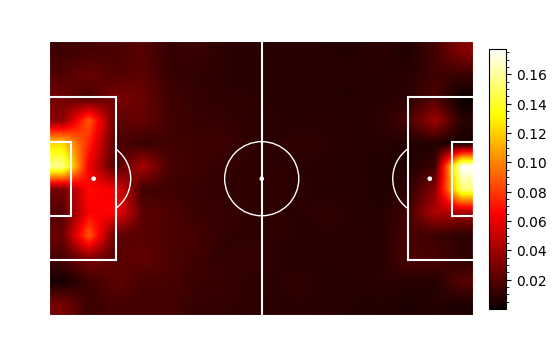

<Axes: >

In [ ]:
# Inspect the interpolated heatmap used for predictions
interp = xTModel.interpolator()
x = np.linspace(0, 105, 1050)
y = np.linspace(0, 68, 680)
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")

In [ ]:
# Extracting drawn matches for Real Madrid
real_draw_home = list(matches[(matches['label'].str.contains('Real Madrid'))&(matches['winner']==0)&(matches['venue']=='Estadio Santiago Bernabéu')]['wyId'])
gmes = games[games['game_id'].isin(real_draw_home)]

In [ ]:
# Extracting the necessary features
A = []
for id, game in tqdm(gmes.iterrows(), total=len(gmes)):

# Extracting Events data from SPAL format
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    A.append(actions)
A = pd.concat(A)
# Getting the xthreat model
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(A)

  0%|          | 0/4 [00:00<?, ?it/s]

# iterations:  33


<ipython-input-107-a008bc0b324e>:5: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


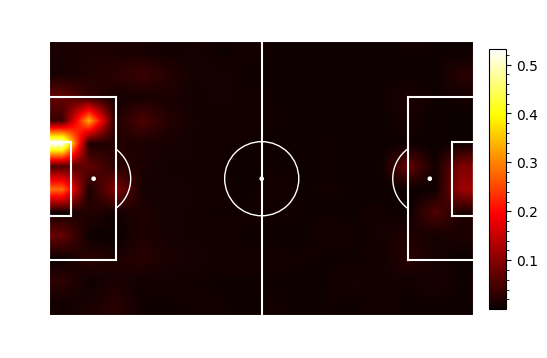

<Axes: >

In [ ]:
# Inspect the interpolated heatmap used for predictions
interp = xTModel.interpolator()
x = np.linspace(0, 105, 1050)
y = np.linspace(0, 68, 680)
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")

In [ ]:
# Extracting drawn matches for Real Madrid
real_draw_away = list(matches[(matches['label'].str.contains('Real Madrid'))&(matches['winner']==0)&(matches['venue']!='Estadio Santiago Bernabéu')]['wyId'])
gmes = games[games['game_id'].isin(real_draw_away)]

In [ ]:
# Extracting the necessary features
A = []
for id, game in tqdm(gmes.iterrows(), total=len(gmes)):

# Extracting Events data from SPAL format
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    A.append(actions)
A = pd.concat(A)
# Getting the xthreat model
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(A)

  0%|          | 0/6 [00:00<?, ?it/s]

# iterations:  38


<ipython-input-111-a008bc0b324e>:5: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


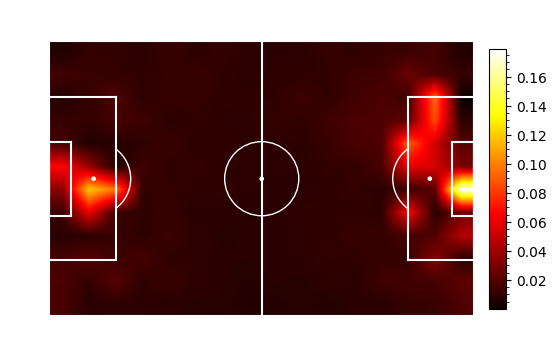

<Axes: >

In [ ]:
# Inspect the interpolated heatmap used for predictions
interp = xTModel.interpolator()
x = np.linspace(0, 105, 1050)
y = np.linspace(0, 68, 680)
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")

In [ ]:
# Extracting lose matches for Real Madrid
real_lose_home = list(matches[(matches['label'].str.contains('Real Madrid'))&(matches['winner']!=0) &(matches['winner']!=675)&(matches['venue']=='Estadio Santiago Bernabéu')]['wyId'])
gmes = games[games['game_id'].isin(real_lose_home)]

In [ ]:
# Extracting the necessary features
A = []
for id, game in tqdm(gmes.iterrows(), total=len(gmes)):

# Extracting Events data from SPAL format
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    A.append(actions)
A = pd.concat(A)
# Getting the xthreat model
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(A)

  0%|          | 0/3 [00:00<?, ?it/s]

# iterations:  34


<ipython-input-114-a008bc0b324e>:5: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


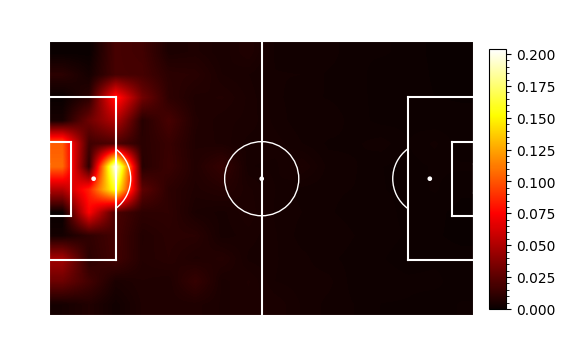

<Axes: >

In [ ]:
# Inspect the interpolated heatmap used for predictions
interp = xTModel.interpolator()
x = np.linspace(0, 105, 1050)
y = np.linspace(0, 68, 680)
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")

In [ ]:
# Extracting lose matches for Real Madrid
real_lose_home = list(matches[(matches['label'].str.contains('Real Madrid'))&(matches['winner']!=0) &(matches['winner']!=675)&(matches['venue']!='Estadio Santiago Bernabéu')]['wyId'])
gmes = games[games['game_id'].isin(real_lose_home)]

In [ ]:
# Extracting the necessary features
A = []
for id, game in tqdm(gmes.iterrows(), total=len(gmes)):

# Extracting Events data from SPAL format
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    A.append(actions)
A = pd.concat(A)
# Getting the xthreat model
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(A)

  0%|          | 0/3 [00:00<?, ?it/s]

# iterations:  32


<ipython-input-117-a008bc0b324e>:5: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


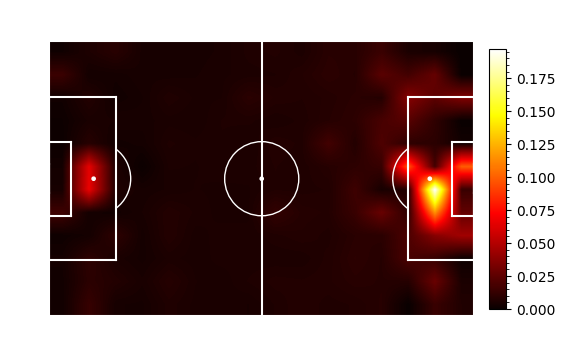

<Axes: >

In [ ]:
# Inspect the interpolated heatmap used for predictions
interp = xTModel.interpolator()
x = np.linspace(0, 105, 1050)
y = np.linspace(0, 68, 680)
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")